See notebook 4.1 for the description of the tutorial. This notebook contains step (4). 

In [48]:
import os
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.optimize import curve_fit
from astropy.table import Table
from jjmodel.constants import tp,tr
from jjmodel.tools import Timer, rebin_histogram
from jjmodel.input_ import p, a, inp
from jjmodel.funcs import AMR
from jjmodel.analysis import agehist, rhoz_monoage, methist
from jjmodel.plotting import Plotting
from matplotlib.ticker import FormatStrFormatter


fnt1, fnt2 = 16, 12 
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


## Step 4. Fitting the reconstructed AMR


In [2]:
# Read tables for runs with bins at 4,5,...,14 kpc and +0.25 kpc and +0.5 kpc shift
# ----------------------------------------------------------------------------------
# R-grids for which we reconstructed AMR (notebook 4.1)
# run0 = 4.5,5.5,...,13.5    kpc      model+z-weights and model+z-weights+warp
# run1 = 4.75,5.75,...,13.75 kpc      model+z-weights 
# run2 = 5.0,6.0,...,14.0    kpc      -//-  
# run3 = 5.25,6.25,...,14.25 kpc      -//-
# run4 = 4.25,4.75,...,13.75 kpc      -//-

# R-grids
R0 = np.arange(4.5,14.5,1.0)
R1 = np.add(R0,0.25)
R2 = np.add(R0,0.5)
R3 = np.add(R0,0.75)
R4 = np.arange(4.25,14.0,0.5)
Rbins, Rbins4 = len(R0), len(R4)

dir0 = os.path.join('output','4.5R13.5_dR1.0_tutorial4_model+zw_newfit_dm')
dir1 = os.path.join('output','4.75R13.75_dR1.0_tutorial4_model+zw_newfit_dm')
dir2 = os.path.join('output','5.0R14.0_dR1.0_tutorial4_model+zw_newfit_dm')
dir3 = os.path.join('output','5.25R14.25_dR1.0_tutorial4_model+zw_newfit_dm')
dir4 = os.path.join('output','4.25R13.75_dR0.5_tutorial4_model+zw_newfit_dm')

amrd_raw0 = np.loadtxt(os.path.join(dir0,'met','tab','AMRd_apogee_rc_dr16_zw.txt')).T
amrd_raw0w = np.loadtxt(os.path.join(dir0,'met','tab','AMRd_apogee_rc_dr16_zw_warp.txt')).T
amrd_raw1 = np.loadtxt(os.path.join(dir1,'met','tab','AMRd_apogee_rc_dr16_zw.txt')).T
amrd_raw2 = np.loadtxt(os.path.join(dir2,'met','tab','AMRd_apogee_rc_dr16_zw.txt')).T
amrd_raw3 = np.loadtxt(os.path.join(dir3,'met','tab','AMRd_apogee_rc_dr16_zw.txt')).T
amrd_raw4 = np.loadtxt(os.path.join(dir4,'met','tab','AMRd_apogee_rc_dr16_zw.txt')).T

# First column is time
AMRd_raw0 = amrd_raw0[1:]
AMRd_raw0w = amrd_raw0w[1:]
AMRd_raw1 = amrd_raw1[1:]
AMRd_raw2 = amrd_raw2[1:]
AMRd_raw3 = amrd_raw3[1:]
AMRd_raw4 = amrd_raw4[1:]


In [3]:
# Definitions of some useful functions
# -------------------------------------

def f_p1(r,p0,p1):
    # 1st-order polynom
    par = p0 + p1*(r/p.Rsun)
    return par


def f_amrd5n(t,t01,r1,t02,r2,FeH_0,FeH_p,aw):
    # Equation to fit the thin-disk AMR
    FeH = FeH_0 + (FeH_p - FeH_0)*\
          (aw*np.tanh(t/t01)**r1/np.tanh(tp/t01)**r1 + (1-aw)*np.tanh(t/t02)**r2/np.tanh(tp/t02)**r2)
    return FeH
    

def get_max_age_index(array):
    # Returns max time index of the updated AMR up to which the AMR can be used for fitting. 
    # A sub-array AMR[ind_age:] is filled with constant AMR[ind_age], which means that 
    # the routine for AMR reconstruction doesn't have enough data to get the AMR shape there 
    # (because some ages are not present in RC sample, see the age distribution plots above). 
    
    ind_age = []
    age_max = 12  # Gyr, max age up to which use AMR for fitting, 
                  # regardless of the derived AMR shape 
    for i in range(len(array)):
        d_array = np.diff(array[i])
        index = np.where(np.abs(d_array)>1e-3)[0][-1]
        if index > int(age_max//tr):
            ind_age.append(int(age_max//tr))
        else:
            ind_age.append(index)
    return ind_age


def ind_br(R_br,R):
    # Returns index of R_br in array R 
    # (if R_br not in R, index corresponds to the closest value smaller than R_br)
    ind_br = int(np.where((R-R_br)<=0)[0][-1] + 1)
    return ind_br


def mixed_array_Nbreaks(arrays,ind_breaks,ind_cut):
    # Takes a list of N arrays (R-grids) and sorts them into M arrays
    # according to the given position of break points. 
    # ind_cut specifies how many points in the beginning and in the end of each array 
    # need to be ignored. 
    n_arr = len(arrays)
    n_brp = len(ind_breaks[0])
    
    ind = np.zeros((n_arr,n_brp+2))
    for k in range(n_arr):
        ind[k][0] = ind_cut[k][0]
        ind[k][-1] = len(arrays[k]) - ind_cut[k][1]
        ind[k][1:-1] = ind_breaks[k]    
    ind = np.array(ind,dtype=np.int)
    
    mix = []
    for i in range(n_brp+1):
        mix.append([])
        for k in range(n_arr):
            mix[i].extend(arrays[k][ind[k][i]:ind[k][i+1]])
    
    return mix


def mixed_array_simple(arrays,ind_cut):
    # Takes a list of N arrays and combines them to a single array. 
    # ind_cut specifies how many points in the beginning and in the end of each array 
    # need to be ignored.
    n_arr = len(arrays)

    ind = np.zeros((n_arr,2))
    for k in range(n_arr):
        ind[k][0] = ind_cut[k][0]
        ind[k][1] = len(arrays[k]) - ind_cut[k][1]
    ind = np.array(ind,dtype=np.int)
    
    mix = []
    for k in range(n_arr):
        mix.extend(arrays[k][ind[k][0]:ind[k][1]])
    
    return mix


def t0_fit_Nbreaks(R,t0,ind_breaks,ind_cut):
    # Fits AMR parameter t0 with a linear radial profile. 
    # ind_breaks is a list of break points, 
    # ind_cut defines how many points in t0 have to be ignored 
    # ([0,0] means the full array, i.e. remove 0 points in the beginning and 0 in the end). 
    
    n_brp = len(ind_breaks)
    
    ind = np.zeros((n_brp+2))
    ind[0] = ind_cut[0]
    ind[-1] = len(R) - ind_cut[1]
    ind[1:-1] = ind_breaks
    ind = np.array(ind,dtype=np.int)
    
    popt = []
    for i in range(n_brp+1):
        popt.append(curve_fit(f_p1,R[ind[i]:ind[i+1]],t0[ind[i]:ind[i+1]])[0])
      
    return popt


def fit_amrd_full(R,array,ia):
    # Fits AMR (array) calculated for R bins with eq. f_amrd5n. 
    # ia is a list of the max time indices at each R (see function get_max_age_index). 
    
    dR = np.mean(np.diff(R))
    fehp_max = [ar[i] + 0.1 for (ar,i) in zip(array,ia)] 
    fehp_min = [ar[i] + 0.0 for (ar,i) in zip(array,ia)]
    
    print('{:^12}'.format('R [kpc]'),'{:<11}'.format('t01'),'{:<11}'.format('rd1'),'{:<11}'.format('t02'),
          '{:<11}'.format('rd2'),'{:<11}'.format('feh0'),'{:<11}'.format('fehp'),'{:<11}'.format('aw'))
          
    t01,rd1,t02,rd2,feh0,fehp,aw = [],[],[],[],[],[],[]
    et01,erd1,et02,erd2,efeh0,efehp,eaw = [],[],[],[],[],[],[]
    
    for i in range(len(R)):
        popt, pcov = curve_fit(f_amrd5n,a.t[:ia[i]],array[i][:ia[i]],
                               bounds=([0,0.0,0,1.0,-1.0,fehp_min[i],0],[10,1.0,10,2.0,-0.5,fehp_max[i],1]),
                               p0=[5,0.9,5,1.8,-0.7,np.mean([fehp_min[i],fehp_max[i]]),0.5])
        [ar.append(par) for (ar,par) in zip ((t01,rd1,t02,rd2,feh0,fehp,aw),popt)]
        [ear.append(epar) for (ear,epar) in zip ((et01,erd1,et02,erd2,efeh0,efehp,eaw),np.sqrt(np.diag(pcov)))]
        popt = np.round(popt,2)
        print('{:^12}'.format(str(R[i]-dR/2)+'-'+str(R[i]+dR/2)),
              '{:<11}'.format(popt[0]),'{:<11}'.format(popt[1]),'{:<11}'.format(popt[2]),
              '{:<11}'.format(popt[3]),'{:<11}'.format(popt[4]),'{:<11}'.format(popt[5]),'{:<11}'.format(popt[6]))
    print('\n')
    
    return ((t01,rd1,t02,rd2,feh0,fehp,aw), (et01,erd1,et02,erd2,efeh0,efehp,eaw))


def fit_amrd_reduced1(R,array,ia,feh0,fehp):
    # Same as fit_amrd_full, but with fixed FeH0 and FeHp. 

    dR = np.mean(np.diff(R))
    
    print('{:^12}'.format('R [kpc]'),'{:<11}'.format('t01'),'{:<11}'.format('rd1'),
          '{:<11}'.format('t02'),'{:<11}'.format('rd2'),'{:<11}'.format('aw'))
          
    t01,t02,rd1,rd2,aw = [],[],[],[],[]
    et01,et02,erd1,erd2,eaw = [],[],[],[],[]
    
    for i in range(len(R)):
        
        def f_amrd_reduced(t,t01,rd1,t02,rd2,aw):              
            return f_amrd5n(t,t01,rd1,t02,rd2,feh0[i],fehp[i],aw)

        popt, pcov = curve_fit(f_amrd_reduced,a.t[:ia[i]],array[i][:ia[i]],
                               bounds=([0,0,0,1,0],[10,1,10,2,1]),p0=[5,0.9,5,1.8,0.5])
        [ar.append(par) for (ar,par) in zip ((t01,rd1,t02,rd2,aw),popt)]
        [ear.append(epar) for (ear,epar) in zip ((et01,erd1,et02,erd2,eaw),np.sqrt(np.diag(pcov)))]
        popt = np.round(popt,2)
        print('{:^12}'.format(str(R[i]-dR/2)+'-'+str(R[i]+dR/2)),
              '{:<11}'.format(popt[0]),'{:<11}'.format(popt[1]),'{:<11}'.format(popt[2]),
              '{:<11}'.format(popt[3]),'{:<11}'.format(popt[4]))
    print('\n')
    
    return ((t01,rd1,t02,rd2,aw), (et01,erd1,et02,erd2,eaw))


def fit_amrd_reduced2(R,array,ia,rd1,rd2,feh0,fehp):
    # Same as fit_amrd_full, but with fixed FeH0, FeHp, rd1, rd2. 

    dR = np.mean(np.diff(R))
    
    print('{:^12}'.format('R [kpc]'),'{:<11}'.format('t01'),'{:<11}'.format('t02'),'{:<11}'.format('aw'))
          
    t01,t02,aw = [],[],[]
    et01,et02,eaw = [],[],[]
    
    for i in range(len(R)):
        
        def f_amrd_reduced(t,t01,t02,aw):              
            return f_amrd5n(t,t01,rd1[i],t02,rd2[i],feh0[i],fehp[i],aw)

        popt, pcov = curve_fit(f_amrd_reduced,a.t[:ia[i]],array[i][:ia[i]],
                               bounds=([0,0,0],[3,10,1]),p0=[1,5,0.5])
        [ar.append(par) for (ar,par) in zip ((t01,t02,aw),popt)]
        [ear.append(epar) for (ear,epar) in zip ((et01,et02,eaw),np.sqrt(np.diag(pcov)))]
        popt = np.round(popt,2)
        print('{:^12}'.format(str(R[i]-dR/2)+'-'+str(R[i]+dR/2)),
              '{:<11}'.format(popt[0]),'{:<11}'.format(popt[1]),'{:<11}'.format(popt[2]))
    print('\n')
    
    return ((t01,t02,aw), (et01,et02,eaw))


def fit_amrd_reduced3(R,array,ia,rd1,rd2,feh0,fehp,aw):
    # Same as fit_amrd_full, but with fixed FeH0, FeHp, rd1, rd2, aw. 
    
    dR = np.mean(np.diff(R))
    
    print('{:^12}'.format('R [kpc]'),'{:<11}'.format('t01'),'{:<11}'.format('t02'))
          
    t01,t02 = [],[]
    et01,et02 = [],[]
    
    for i in range(len(R)):
        
        def f_amrd_reduced(t,t01,t02):              
            return f_amrd5n(t,t01,rd1[i],t02,rd2[i],feh0[i],fehp[i],aw[i])

        popt, pcov = curve_fit(f_amrd_reduced,a.t[:ia[i]],array[i][:ia[i]],bounds=([0,0],[3,10]),p0=[1,5])
        [ar.append(par) for (ar,par) in zip ((t01,t02),popt)]
        [ear.append(epar) for (ear,epar) in zip ((et01,et02),np.sqrt(np.diag(pcov)))]
        popt = np.round(popt,2)
        print('{:^12}'.format(str(R[i]-dR/2)+'-'+str(R[i]+dR/2)),
              '{:<11}'.format(popt[0]),'{:<11}'.format(popt[1]))
    print('\n')
    
    return ((t01,t02), (et01,et02))



We find, that if we simultaneously fit all parameters of the AMR equation (function f_amrd5n) with simple radial 
profiles, the 'generalized' or 'global' AMR calculated with the parameters corresponding to these analytic radial laws significantly deviates from the best-fit or 'raw' AMR which we obtained in the end of the notebook 4.1. 

To find the radial profiles of the AMR parameters which correspond to the AMR well consistent with the 'raw' reconstructed AMR, we fit parameters step by step in the following way:

  - Fit the 'raw' AMR at each R using the function f_amrd5n. 
  - Fit the obtained [Fe/H]0 and [Fe/H]p parameters with linear profiles (for [Fe/H]p - with a break). 
    With these two parameters fixed, fit the reconstructed 'raw' AMR and find the optimal values
    of the remaining five parameters. 
  - Then fit rd1 and rd2 with linear profiles (we adopt constants) and optimize the remaining t01, t02, and aw. 
  - Fit parameter aw with a linear profile, and find the best t01 and t02 assuming the rest of parameters fixed. 
  - Finally, adopt fits for t01 and t02 (e.g. linear with 2 breaks). 


  R [kpc]    t01         rd1         t02         rd2         feh0        fehp        aw         
  4.0-5.0    0.74        0.39        3.25        1.65        -1.0        0.42        0.8        
  5.0-6.0    1.05        0.68        4.52        2.0         -0.75       0.4         0.72       
  6.0-7.0    1.05        0.79        3.86        2.0         -0.7        0.42        0.68       
  7.0-8.0    1.77        0.36        3.96        1.17        -0.8        0.32        0.4        
  8.0-9.0    1.85        0.62        4.75        1.67        -0.75       0.22        0.52       
  9.0-10.0   6.6         0.29        4.5         2.0         -1.0        0.12        0.84       
 10.0-11.0   6.87        0.32        6.36        2.0         -1.0        0.09        0.81       
 11.0-12.0   6.5         0.45        6.06        2.0         -0.84       0.02        0.8        
 12.0-13.0   5.89        0.39        5.85        2.0         -0.81       -0.07       0.68       
 13.0-14.0   6.18        0.79 

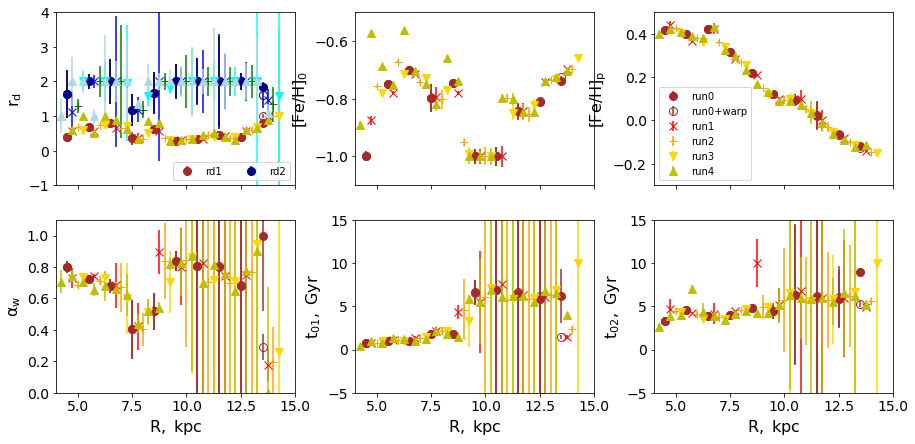

In [5]:
# (i) Fit AMR (find best-fit parameters at each R)
# ----------------------------------------------------

ia0 = get_max_age_index(AMRd_raw0)
ia0w = get_max_age_index(AMRd_raw0w)
ia1 = get_max_age_index(AMRd_raw1)
ia2 = get_max_age_index(AMRd_raw2)
ia3 = get_max_age_index(AMRd_raw3)
ia4 = get_max_age_index(AMRd_raw4)

amrd_fit0 = fit_amrd_full(R0,AMRd_raw0,ia0)
amrd_fit0w = fit_amrd_full(R0,AMRd_raw0w,ia0w)
amrd_fit1 = fit_amrd_full(R1,AMRd_raw1,ia1)
amrd_fit2 = fit_amrd_full(R2,AMRd_raw2,ia2)
amrd_fit3 = fit_amrd_full(R3,AMRd_raw3,ia3)
amrd_fit4 = fit_amrd_full(R4,AMRd_raw4,ia4)
((t01_run0,rd1_run0,t02_run0,rd2_run0,feh0_run0,fehp_run0,aw_run0),
(et01_run0,erd1_run0,et02_run0,erd2_run0,efeh0_run0,efehp_run0,eaw_run0)) = amrd_fit0
((t01_run0w,rd1_run0w,t02_run0w,rd2_run0w,feh0_run0w,fehp_run0w,aw_run0w),
(et01_run0w,erd1_run0w,et02_run0w,erd2_run0w,efeh0_run0w,efehp_run0w,eaw_run0w)) = amrd_fit0w
((t01_run1,rd1_run1,t02_run1,rd2_run1,feh0_run1,fehp_run1,aw_run1),
(et01_run1,erd1_run1,et02_run1,erd2_run1,efeh0_run1,efehp_run1,eaw_run1)) = amrd_fit1
((t01_run2,rd1_run2,t02_run2,rd2_run2,feh0_run2,fehp_run2,aw_run2),
(et01_run2,erd1_run2,et02_run2,erd2_run2,efeh0_run2,efehp_run2,eaw_run2)) = amrd_fit2
((t01_run3,rd1_run3,t02_run3,rd2_run3,feh0_run3,fehp_run3,aw_run3),
(et01_run3,erd1_run3,et02_run3,erd2_run3,efeh0_run3,efehp_run3,eaw_run3)) = amrd_fit3
((t01_run4,rd1_run4,t02_run4,rd2_run4,feh0_run4,fehp_run4,aw_run4),
(et01_run4,erd1_run4,et02_run4,erd2_run4,efeh0_run4,efehp_run4,eaw_run4)) = amrd_fit4


# Plot parameters and their profiles
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,7))
mrks = 8

# rd1 and rd2 
ax[0,0].errorbar(R0,rd1_run0,yerr=erd1_run0,c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
ax[0,0].errorbar(R0,rd1_run0w,yerr=erd1_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[0,0].errorbar(R1,rd1_run1,yerr=erd1_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd1_run2,yerr=erd1_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd1_run3,yerr=erd1_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd1_run4,yerr=erd1_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,0].errorbar(R0,rd2_run0,yerr=erd2_run0,c='navy',ls='none',marker='o',markersize=mrks,label='rd2')
ax[0,0].errorbar(R0,rd2_run0w,yerr=erd2_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='navy',ecolor='navy')
ax[0,0].errorbar(R1,rd2_run1,yerr=erd2_run1,c='b',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd2_run2,yerr=erd2_run2,c='g',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd2_run3,yerr=erd2_run3,c='cyan',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd2_run4,yerr=erd2_run4,c='lightblue',ls='none',marker='^',markersize=mrks)
ax[0,0].set_ylabel('$\mathrm{r_d}$',fontsize=fnt1)
ax[0,0].legend(loc=4,ncol=2)
ax[0,0].set_ylim(-1,4)
ax[0,0].set_xlim(4,15)
ax[0,0].set_xticklabels([])
# FeH0
ax[0,1].errorbar(R0,feh0_run0,yerr=efeh0_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[0,1].errorbar(R0,feh0_run0w,yerr=efeh0_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[0,1].errorbar(R1,feh0_run1,yerr=efeh0_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,1].errorbar(R2,feh0_run2,yerr=efeh0_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,1].errorbar(R3,feh0_run3,yerr=efeh0_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,1].errorbar(R4,feh0_run4,yerr=efeh0_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,1].set_ylabel('$\mathrm{[Fe/H]_0}$',fontsize=fnt1)
ax[0,1].set_ylim(-1.1,-0.5)
ax[0,1].set_xlim(4,15)
ax[0,1].set_xticklabels([])
# FeHp
ax[0,2].errorbar(R0,fehp_run0,yerr=efehp_run0,c='brown',ls='none',marker='o',markersize=mrks,label='run0')
ax[0,2].errorbar(R0,fehp_run0w,yerr=efehp_run0w,ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown',label='run0+warp',ecolor='brown')
ax[0,2].errorbar(R1,fehp_run1,yerr=efehp_run1,c='red',ls='none',marker='x',markersize=mrks,label='run1')
ax[0,2].errorbar(R2,fehp_run2,yerr=efehp_run2,c='orange',ls='none',marker='+',markersize=mrks,label='run2')
ax[0,2].errorbar(R3,fehp_run3,yerr=efehp_run3,c='gold',ls='none',marker='v',markersize=mrks,label='run3')
ax[0,2].errorbar(R4,fehp_run4,yerr=efehp_run4,c='y',ls='none',marker='^',markersize=mrks,label='run4')
ax[0,2].set_ylabel('$\mathrm{[Fe/H]_p}$',fontsize=fnt1)
ax[0,2].set_ylim(-0.3,0.5)
ax[0,2].set_xlim(4,15)
ax[0,2].legend(loc=3)
ax[0,2].set_xticklabels([])
# Aw
ax[1,0].errorbar(R0,aw_run0,yerr=eaw_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,0].errorbar(R0,aw_run0w,yerr=eaw_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[1,0].errorbar(R1,aw_run1,yerr=eaw_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,0].errorbar(R2,aw_run2,yerr=eaw_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,0].errorbar(R3,aw_run3,yerr=eaw_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,0].errorbar(R4,aw_run4,yerr=eaw_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,0].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,0].set_ylabel(r'$\mathrm{\alpha_w}$',fontsize=fnt1)
ax[1,0].set_ylim(0,1.1)
ax[1,0].set_xlim(4,15)
# t01
ax[1,1].errorbar(R0,t01_run0,yerr=et01_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,1].errorbar(R0,t01_run0w,yerr=et01_run0w,ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[1,1].errorbar(R1,t01_run1,yerr=et01_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,1].errorbar(R2,t01_run2,yerr=et01_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,1].errorbar(R3,t01_run3,yerr=et01_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,1].errorbar(R4,t01_run4,yerr=et01_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,1].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,1].set_ylabel(r'$\mathrm{t_{01}, \ Gyr}$',fontsize=fnt1)
ax[1,1].set_ylim(-5,15)
ax[1,1].set_xlim(4,15)
# t02
ax[1,2].errorbar(R0,t02_run0,yerr=et02_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,2].errorbar(R0,t02_run0w,yerr=et02_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[1,2].errorbar(R1,t02_run1,yerr=et02_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,2].errorbar(R2,t02_run2,yerr=et02_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,2].errorbar(R3,t02_run3,yerr=et02_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,2].errorbar(R4,t02_run4,yerr=et02_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,2].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,2].set_ylabel(r'$\mathrm{t_{02}, \ Gyr}$',fontsize=fnt1)
ax[1,2].set_ylim(-5,15)
ax[1,2].set_xlim(4,15)
fig.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig(os.path.join('output','AMRd_best_params_runs0-4_dm_step1.png'))



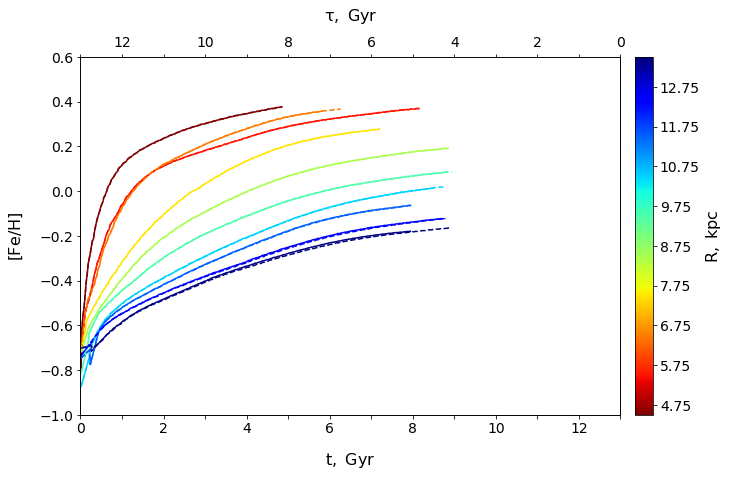

In [7]:
# Plot of the reconstructed thin-disk AMR for one of the runs, with and without warp 
# (difference is negligible)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim((0,tp))
ax.set_ylim((-1.0,0.6))
ax.set_xticks(np.arange(tp+1))
ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
ax.set_ylabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
axx = ax.twiny()
axx.set_xticks(np.arange(tp+1))
axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)

line_segments1 = LineCollection([list(zip(a.t[:ia0[i]],AMRd_raw0[i][:ia1[i]])) for i in np.arange(len(R0))],
                                 linewidths=1.5,cmap = mpl.cm.jet_r,
                                 norm = mpl.colors.Normalize(vmin=R0[0],vmax=R0[-1]))   
line_segments2 = LineCollection([list(zip(a.t[:ia0w[i]],AMRd_raw0w[i][:ia0w[i]])) for i in np.arange(len(R0))],
                                 linewidths=1.5,cmap = mpl.cm.jet_r,ls='--',
                                 norm = mpl.colors.Normalize(vmin=R0[0],vmax=R0[-1]))   
line_segments1.set_array(R0)
im = ax.add_collection(line_segments1)
line_segments2.set_array(R0)
im = ax.add_collection(line_segments2)
pos = ax.get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = fig.colorbar(im,cax=cax,orientation='vertical')
cbar.set_ticks(R1)
cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
plt.show()


  R [kpc]    t01         rd1         t02         rd2         aw         
  4.0-5.0    0.59        0.53        3.51        1.0         0.7        
  5.0-6.0    1.14        0.51        7.35        1.0         0.67       
  6.0-7.0    1.1         0.52        2.96        2.0         0.71       
  7.0-8.0    3.37        0.33        3.63        1.29        0.57       
  8.0-9.0    2.25        0.34        5.38        1.0         0.43       
  9.0-10.0   5.52        0.47        10.0        1.89        0.88       
 10.0-11.0   6.82        0.51        6.56        2.0         0.89       
 11.0-12.0   6.06        0.45        5.91        2.0         0.78       
 12.0-13.0   10.0        0.34        5.17        2.0         0.76       
 13.0-14.0   1.8         0.12        5.57        1.0         0.23       


  R [kpc]    t01         rd1         t02         rd2         aw         
  4.0-5.0    0.59        0.53        3.51        1.0         0.7        
  5.0-6.0    1.15        0.51        7.42        

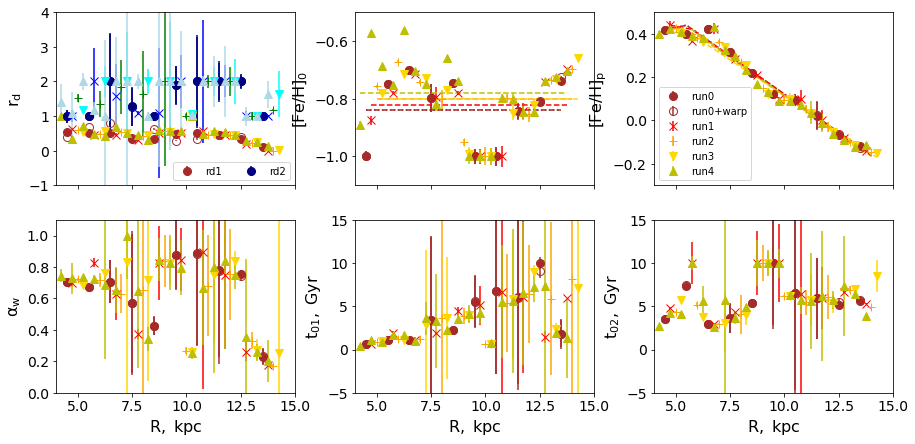

In [8]:
# (ii). Fix FeH0 and FeHp, fit (t01, rd1, t02, rd2, Aw) 
# -----------------------------------------------------

# Fit FeH0 with a linear law
popt_feh0_run0, pcov = curve_fit(f_p1,R0,feh0_run0)
popt_feh0_run0w, pcov = curve_fit(f_p1,R0,feh0_run0w)
popt_feh0_run1, pcov = curve_fit(f_p1,R1,feh0_run1)
popt_feh0_run2, pcov = curve_fit(f_p1,R2,feh0_run2)
popt_feh0_run3, pcov = curve_fit(f_p1,R3,feh0_run3)
popt_feh0_run4, pcov = curve_fit(f_p1,R4,feh0_run4)

# And find the mean (for FeH0 we adopt constant at each R)
feh0_fit_run01 = f_p1(R0,*popt_feh0_run0)
feh0_fit_run0 = [np.round(np.mean(feh0_fit_run01),2) for i in R0]
feh0_fit_run01w = f_p1(R0,*popt_feh0_run0w)
feh0_fit_run0w = [np.round(np.mean(feh0_fit_run01w),2) for i in R0]
feh0_fit_run11 = f_p1(R1,*popt_feh0_run1)
feh0_fit_run1 = [np.round(np.mean(feh0_fit_run11),2) for i in R1]
feh0_fit_run21 = f_p1(R2,*popt_feh0_run2)
feh0_fit_run2 = [np.round(np.mean(feh0_fit_run21),2) for i in R2]
feh0_fit_run31 = f_p1(R3,*popt_feh0_run3)
feh0_fit_run3 = [np.round(np.mean(feh0_fit_run31),2) for i in R3]
feh0_fit_run41 = f_p1(R4,*popt_feh0_run4)
feh0_fit_run4 = [np.round(np.mean(feh0_fit_run41),2) for i in R4]

# For FeHp we use a broken linear law
R_br_fehp = 6.0   # kpc, position of the break 
'''
ib_fehp_run0 = ind_br(R_br_fehp,R0)
ib_fehp_run1 = ind_br(R_br_fehp,R1)
ib_fehp_run2 = ind_br(R_br_fehp,R2)
ib_fehp_run3 = ind_br(R_br_fehp,R3)
ib_fehp_run4 = ind_br(R_br_fehp,R4)
'''

def f_p1_fehp(r,p01,p11,p12):
    # 2-slope broken linear law with a break at R_br_fehp 
    #p11 = 0 
    p02 = p01 + (p11-p12)*R_br_fehp/p.Rsun
    ind_br = np.where(r<=R_br_fehp)[0][-1]
    par1 = p01 + p11*(r[:ind_br]/p.Rsun)
    par2 = p02 + p12*(r[ind_br:]/p.Rsun)
    par = np.concatenate((par1,par2),axis=0)
    return par

popt_fehp_run0 = curve_fit(f_p1_fehp,R0,fehp_run0)[0]
popt_fehp_run0w = curve_fit(f_p1_fehp,R0,fehp_run0w)[0]
popt_fehp_run1 = curve_fit(f_p1_fehp,R1,fehp_run1)[0]
popt_fehp_run2 = curve_fit(f_p1_fehp,R2,fehp_run2)[0]
popt_fehp_run3 = curve_fit(f_p1_fehp,R3,fehp_run3)[0]
popt_fehp_run4 = curve_fit(f_p1_fehp,R4,fehp_run4)[0]

fehp_fit_run0 = f_p1_fehp(R0,*popt_fehp_run0)
fehp_fit_run0w = f_p1_fehp(R0,*popt_fehp_run0w)
fehp_fit_run1 = f_p1_fehp(R1,*popt_fehp_run1)
fehp_fit_run2 = f_p1_fehp(R2,*popt_fehp_run2)
fehp_fit_run3 = f_p1_fehp(R3,*popt_fehp_run3)
fehp_fit_run4 = f_p1_fehp(R4,*popt_fehp_run4)


# Fit AMR 
amrd_fit0 = fit_amrd_reduced1(R0,AMRd_raw0,ia0,feh0_fit_run0,fehp_fit_run0)
amrd_fit0w = fit_amrd_reduced1(R0,AMRd_raw0w,ia0w,feh0_fit_run0w,fehp_fit_run0w)
amrd_fit1 = fit_amrd_reduced1(R1,AMRd_raw1,ia1,feh0_fit_run1,fehp_fit_run1)
amrd_fit2 = fit_amrd_reduced1(R2,AMRd_raw2,ia2,feh0_fit_run2,fehp_fit_run2)
amrd_fit3 = fit_amrd_reduced1(R3,AMRd_raw3,ia3,feh0_fit_run3,fehp_fit_run3)
amrd_fit4 = fit_amrd_reduced1(R4,AMRd_raw4,ia4,feh0_fit_run4,fehp_fit_run4)
(t01_run0,rd1_run0,t02_run0,rd2_run0,aw_run0),(et01_run0,erd1_run0,et02_run0,erd2_run0,eaw_run0) = amrd_fit0
((t01_run0w,rd1_run0,t02_run0w,rd2_run0w,aw_run0w),
(et01_run0w,erd1_run0w,et02_run0w,erd2_run0w,eaw_run0w)) = amrd_fit0w
(t01_run1,rd1_run1,t02_run1,rd2_run1,aw_run1),(et01_run1,erd1_run1,et02_run1,erd2_run1,eaw_run1) = amrd_fit1
(t01_run2,rd1_run2,t02_run2,rd2_run2,aw_run2),(et01_run2,erd1_run2,et02_run2,erd2_run2,eaw_run2) = amrd_fit2
(t01_run3,rd1_run3,t02_run3,rd2_run3,aw_run3),(et01_run3,erd1_run3,et02_run3,erd2_run3,eaw_run3) = amrd_fit3
(t01_run4,rd1_run4,t02_run4,rd2_run4,aw_run4),(et01_run4,erd1_run4,et02_run4,erd2_run4,eaw_run4) = amrd_fit4


# Plot parameters and their profiles
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,7))
mrks = 8
# rd1 and rd2 
ax[0,0].errorbar(R0,rd1_run0,yerr=erd1_run0,c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
ax[0,0].errorbar(R0,rd1_run0w,yerr=erd1_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown',ecolor='brown')
ax[0,0].errorbar(R1,rd1_run1,yerr=erd1_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd1_run2,yerr=erd1_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd1_run3,yerr=erd1_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd1_run4,yerr=erd1_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,0].errorbar(R0,rd2_run0,yerr=erd2_run0,c='navy',ls='none',marker='o',markersize=mrks,label='rd2')
ax[0,0].errorbar(R0,rd2_run0w,yerr=erd2_run0w,ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='navy',ecolor='navy')
ax[0,0].errorbar(R1,rd2_run1,yerr=erd2_run1,c='b',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd2_run2,yerr=erd2_run2,c='g',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd2_run3,yerr=erd2_run3,c='cyan',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd2_run4,yerr=erd2_run4,c='lightblue',ls='none',marker='^',markersize=mrks)
ax[0,0].set_ylabel('$\mathrm{r_d}$',fontsize=fnt1)
ax[0,0].legend(loc=4,ncol=2)
ax[0,0].set_ylim(-1,4)
ax[0,0].set_xlim(4,15)
ax[0,0].set_xticklabels([])
# FeH0
ax[0,1].errorbar(R0,feh0_run0,yerr=efeh0_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[0,1].errorbar(R0,feh0_run0w,yerr=efeh0_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                 markerfacecolor='none',markeredgecolor='brown')
ax[0,1].errorbar(R1,feh0_run1,yerr=efeh0_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,1].errorbar(R2,feh0_run2,yerr=efeh0_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,1].errorbar(R3,feh0_run3,yerr=efeh0_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,1].errorbar(R4,feh0_run4,yerr=efeh0_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,1].plot(R0,feh0_fit_run0,c='brown',ls='--')
ax[0,1].plot(R0,feh0_fit_run0w,c='brown',ls=':')
ax[0,1].plot(R1,feh0_fit_run1,c='red',ls='--')
ax[0,1].plot(R2,feh0_fit_run2,c='orange',ls='--')
ax[0,1].plot(R3,feh0_fit_run3,c='gold',ls='--')
ax[0,1].plot(R4,feh0_fit_run4,c='y',ls='--')
ax[0,1].set_ylabel('$\mathrm{[Fe/H]_0}$',fontsize=fnt1)
ax[0,1].set_ylim(-1.1,-0.5)
ax[0,1].set_xlim(4,15)
ax[0,1].set_xticklabels([])
# FeHp
ax[0,2].errorbar(R0,fehp_run0,yerr=efehp_run0,c='brown',ls='none',marker='o',markersize=mrks,label='run0')
ax[0,2].errorbar(R0,fehp_run0w,yerr=efehp_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                 label='run0+warp',markerfacecolor='none',markeredgecolor='brown')
ax[0,2].errorbar(R1,fehp_run1,yerr=efehp_run1,c='red',ls='none',marker='x',markersize=mrks,label='run1')
ax[0,2].errorbar(R2,fehp_run2,yerr=efehp_run2,c='orange',ls='none',marker='+',markersize=mrks,label='run2')
ax[0,2].errorbar(R3,fehp_run3,yerr=efehp_run3,c='gold',ls='none',marker='v',markersize=mrks,label='run3')
ax[0,2].errorbar(R4,fehp_run4,yerr=efehp_run4,c='y',ls='none',marker='^',markersize=mrks,label='run4')
ax[0,2].plot(R0,fehp_fit_run0,c='brown',ls='--')
ax[0,2].plot(R0,fehp_fit_run0w,c='brown',ls=':')
ax[0,2].plot(R1,fehp_fit_run1,c='red',ls='--')
ax[0,2].plot(R2,fehp_fit_run2,c='orange',ls='--')
ax[0,2].plot(R3,fehp_fit_run3,c='gold',ls='--')
ax[0,2].plot(R4,fehp_fit_run4,c='y',ls='--')
ax[0,2].set_ylabel('$\mathrm{[Fe/H]_p}$',fontsize=fnt1)
ax[0,2].set_ylim(-0.3,0.5)
ax[0,2].set_xlim(4,15)
ax[0,2].legend(loc=3)
ax[0,2].set_xticklabels([])
# Aw
ax[1,0].errorbar(R0,aw_run0,yerr=eaw_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,0].errorbar(R0,aw_run0w,yerr=eaw_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,0].errorbar(R1,aw_run1,yerr=eaw_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,0].errorbar(R2,aw_run2,yerr=eaw_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,0].errorbar(R3,aw_run3,yerr=eaw_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,0].errorbar(R4,aw_run4,yerr=eaw_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,0].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,0].set_ylabel(r'$\mathrm{\alpha_w}$',fontsize=fnt1)
ax[1,0].set_ylim(0,1.1)
ax[1,0].set_xlim(4,15)
# t01
ax[1,1].errorbar(R0,t01_run0,yerr=et01_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,1].errorbar(R0,t01_run0w,yerr=et01_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,1].errorbar(R1,t01_run1,yerr=et01_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,1].errorbar(R2,t01_run2,yerr=et01_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,1].errorbar(R3,t01_run3,yerr=et01_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,1].errorbar(R4,t01_run4,yerr=et01_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,1].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,1].set_ylabel(r'$\mathrm{t_{01}, \ Gyr}$',fontsize=fnt1)
ax[1,1].set_ylim(-5,15)
ax[1,1].set_xlim(4,15)
# t02
ax[1,2].errorbar(R0,t02_run0,yerr=et02_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,2].errorbar(R0,t02_run0w,yerr=et02_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,2].errorbar(R1,t02_run1,yerr=et02_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,2].errorbar(R2,t02_run2,yerr=et02_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,2].errorbar(R3,t02_run3,yerr=et02_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,2].errorbar(R4,t02_run4,yerr=et02_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,2].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,2].set_ylabel(r'$\mathrm{t_{02}, \ Gyr}$',fontsize=fnt1)
ax[1,2].set_ylim(-5,15)
ax[1,2].set_xlim(4,15)
fig.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig(os.path.join('output','AMRd_best_params_runs0-4_dm_step2.png'))



  R [kpc]    t01         t02         aw         
  4.0-5.0    0.68        3.28        0.76       
  5.0-6.0    1.27        6.55        0.73       
  6.0-7.0    1.03        3.07        0.65       
  7.0-8.0    0.74        3.3         0.4        
  8.0-9.0    1.61        4.91        0.52       
  9.0-10.0   1.98        6.39        0.54       
 10.0-11.0   1.34        5.68        0.39       
 11.0-12.0   1.13        5.43        0.37       
 12.0-13.0   0.88        5.88        0.38       
 13.0-14.0   1.07        5.07        0.36       


  R [kpc]    t01         t02         aw         
  4.0-5.0    0.68        3.28        0.76       
  5.0-6.0    1.28        6.6         0.73       
  6.0-7.0    1.03        3.09        0.65       
  7.0-8.0    0.74        3.31        0.4        
  8.0-9.0    1.6         4.9         0.52       
  9.0-10.0   1.96        6.35        0.54       
 10.0-11.0   1.33        5.67        0.39       
 11.0-12.0   1.13        5.43        0.37       
 12.0-13.0   0.88 

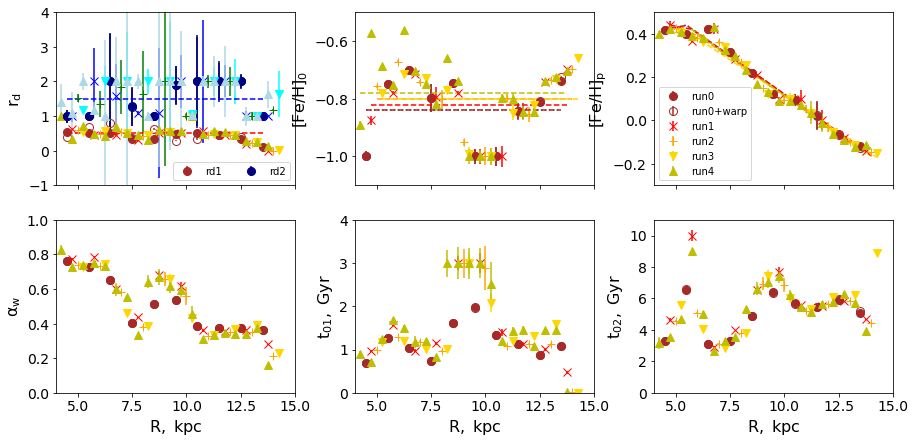

In [9]:
# (iii). Fix rd1 and rd2, fit (t01, t02, Aw) 
# -----------------------------------------------------

# We adopt constants for rd1 and rd2 
rd1_fit = [0.5 for i in R0]
rd2_fit = [1.5 for i in R0]
rd1_fit4 = [0.5 for i in R4]
rd2_fit4 = [1.5 for i in R4]

# Fit AMR
amrd_fit0 = fit_amrd_reduced2(R0,AMRd_raw0,ia0,rd1_fit,rd2_fit,feh0_fit_run0,fehp_fit_run0)
amrd_fit0w = fit_amrd_reduced2(R0,AMRd_raw0w,ia0w,rd1_fit,rd2_fit,feh0_fit_run0w,fehp_fit_run0w)
amrd_fit1 = fit_amrd_reduced2(R1,AMRd_raw1,ia1,rd1_fit,rd2_fit,feh0_fit_run1,fehp_fit_run1)
amrd_fit2 = fit_amrd_reduced2(R2,AMRd_raw2,ia2,rd1_fit,rd2_fit,feh0_fit_run2,fehp_fit_run2)
amrd_fit3 = fit_amrd_reduced2(R3,AMRd_raw3,ia3,rd1_fit,rd2_fit,feh0_fit_run3,fehp_fit_run3)
amrd_fit4 = fit_amrd_reduced2(R4,AMRd_raw4,ia4,rd1_fit4,rd2_fit4,feh0_fit_run4,fehp_fit_run4)
(t01_run0,t02_run0,aw_run0),(et01_run0,et02_run0,eaw_run0) = amrd_fit0
(t01_run0w,t02_run0w,aw_run0w),(et01_run0w,et02_run0w,eaw_run0w) = amrd_fit0w
(t01_run1,t02_run1,aw_run1),(et01_run1,et02_run1,eaw_run1) = amrd_fit1
(t01_run2,t02_run2,aw_run2),(et01_run2,et02_run2,eaw_run2) = amrd_fit2
(t01_run3,t02_run3,aw_run3),(et01_run3,et02_run3,eaw_run3) = amrd_fit3
(t01_run4,t02_run4,aw_run4),(et01_run4,et02_run4,eaw_run4) = amrd_fit4


# Plot parameters and their profiles
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,7))
mrks = 8
# rd1 and rd2 
ax[0,0].errorbar(R0,rd1_run0,yerr=erd1_run0,c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
ax[0,0].errorbar(R0,rd1_run0w,yerr=erd1_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[0,0].errorbar(R1,rd1_run1,yerr=erd1_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd1_run2,yerr=erd1_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd1_run3,yerr=erd1_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd1_run4,yerr=erd1_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,0].errorbar(R0,rd2_run0,yerr=erd2_run0,c='navy',ls='none',marker='o',markersize=mrks,label='rd2')
ax[0,0].errorbar(R0,rd2_run0w,yerr=erd2_run0w,ecolor='navy',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='navy')
ax[0,0].errorbar(R1,rd2_run1,yerr=erd2_run1,c='b',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd2_run2,yerr=erd2_run2,c='g',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd2_run3,yerr=erd2_run3,c='cyan',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd2_run4,yerr=erd2_run4,c='lightblue',ls='none',marker='^',markersize=mrks)
ax[0,0].plot(R0,rd1_fit,ls='--',c='r')
ax[0,0].plot(R0,rd2_fit,ls='--',c='b')
ax[0,0].set_ylabel('$\mathrm{r_d}$',fontsize=fnt1)
ax[0,0].legend(loc=4,ncol=2)
ax[0,0].set_ylim(-1,4)
ax[0,0].set_xlim(4,15)
ax[0,0].set_xticklabels([])
# FeH0
ax[0,1].errorbar(R0,feh0_run0,yerr=efeh0_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[0,1].errorbar(R0,feh0_run0w,yerr=efeh0_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[0,1].errorbar(R1,feh0_run1,yerr=efeh0_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,1].errorbar(R2,feh0_run2,yerr=efeh0_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,1].errorbar(R3,feh0_run3,yerr=efeh0_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,1].errorbar(R4,feh0_run4,yerr=efeh0_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,1].plot(R0,feh0_fit_run0,c='brown',ls='--')
ax[0,1].plot(R0,feh0_fit_run0w,c='brown',ls=':')
ax[0,1].plot(R1,feh0_fit_run1,c='red',ls='--')
ax[0,1].plot(R2,feh0_fit_run2,c='orange',ls='--')
ax[0,1].plot(R3,feh0_fit_run3,c='gold',ls='--')
ax[0,1].plot(R4,feh0_fit_run4,c='y',ls='--')
ax[0,1].set_ylabel('$\mathrm{[Fe/H]_0}$',fontsize=fnt1)
ax[0,1].set_ylim(-1.1,-0.5)
ax[0,1].set_xlim(4,15)
ax[0,1].set_xticklabels([])
# FeHp
ax[0,2].errorbar(R0,fehp_run0,yerr=efehp_run0,c='brown',ls='none',marker='o',markersize=mrks,label='run0')
ax[0,2].errorbar(R0,fehp_run0w,yerr=efehp_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                 label='run0+warp',markerfacecolor='none',markeredgecolor='brown')
ax[0,2].errorbar(R1,fehp_run1,yerr=efehp_run1,c='red',ls='none',marker='x',markersize=mrks,label='run1')
ax[0,2].errorbar(R2,fehp_run2,yerr=efehp_run2,c='orange',ls='none',marker='+',markersize=mrks,label='run2')
ax[0,2].errorbar(R3,fehp_run3,yerr=efehp_run3,c='gold',ls='none',marker='v',markersize=mrks,label='run3')
ax[0,2].errorbar(R4,fehp_run4,yerr=efehp_run4,c='y',ls='none',marker='^',markersize=mrks,label='run4')
ax[0,2].plot(R0,fehp_fit_run0,c='brown',ls='--')
ax[0,2].plot(R0,fehp_fit_run0w,c='brown',ls=':')
ax[0,2].plot(R1,fehp_fit_run1,c='red',ls='--')
ax[0,2].plot(R2,fehp_fit_run2,c='orange',ls='--')
ax[0,2].plot(R3,fehp_fit_run3,c='gold',ls='--')
ax[0,2].plot(R4,fehp_fit_run4,c='y',ls='--')
ax[0,2].set_ylabel('$\mathrm{[Fe/H]_p}$',fontsize=fnt1)
ax[0,2].set_ylim(-0.3,0.5)
ax[0,2].set_xlim(4,15)
ax[0,2].legend(loc=3)
ax[0,2].set_xticklabels([])
# Aw
ax[1,0].errorbar(R0,aw_run0,yerr=eaw_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,0].errorbar(R0,aw_run0w,yerr=eaw_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,0].errorbar(R1,aw_run1,yerr=eaw_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,0].errorbar(R2,aw_run2,yerr=eaw_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,0].errorbar(R3,aw_run3,yerr=eaw_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,0].errorbar(R4,aw_run4,yerr=eaw_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,0].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,0].set_ylabel(r'$\mathrm{\alpha_w}$',fontsize=fnt1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlim(4,15)
# t01
ax[1,1].errorbar(R0,t01_run0,yerr=et01_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,1].errorbar(R0,t01_run0w,yerr=et01_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,1].errorbar(R1,t01_run1,yerr=et01_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,1].errorbar(R2,t01_run2,yerr=et01_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,1].errorbar(R3,t01_run3,yerr=et01_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,1].errorbar(R4,t01_run4,yerr=et01_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,1].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,1].set_ylabel(r'$\mathrm{t_{01}, \ Gyr}$',fontsize=fnt1)
ax[1,1].set_ylim(0,4)
ax[1,1].set_xlim(4,15)
# t02
ax[1,2].errorbar(R0,t02_run0,yerr=et02_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,2].errorbar(R0,t02_run0w,yerr=et02_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,2].errorbar(R1,t02_run1,yerr=et02_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,2].errorbar(R2,t02_run2,yerr=et02_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,2].errorbar(R3,t02_run3,yerr=et02_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,2].errorbar(R4,t02_run4,yerr=et02_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,2].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,2].set_ylabel(r'$\mathrm{t_{02}, \ Gyr}$',fontsize=fnt1)
ax[1,2].set_ylim(0,11)
ax[1,2].set_xlim(4,15)
fig.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig(os.path.join('output','AMRd_best_params_runs0-4_dm_step3.png'))



  R [kpc]    t01         t02        
  4.0-5.0    0.57        2.84       
  5.0-6.0    1.02        5.37       
  6.0-7.0    0.93        2.94       
  7.0-8.0    1.81        3.91       
  8.0-9.0    1.72        5.01       
  9.0-10.0   1.57        5.89       
 10.0-11.0   1.86        6.11       
 11.0-12.0   1.32        5.6        
 12.0-13.0   0.71        5.65       
 13.0-14.0   0.65        4.72       


  R [kpc]    t01         t02        
  4.0-5.0    0.57        2.84       
  5.0-6.0    1.02        5.4        
  6.0-7.0    0.93        2.95       
  7.0-8.0    1.81        3.92       
  8.0-9.0    1.72        5.0        
  9.0-10.0   1.56        5.88       
 10.0-11.0   1.86        6.1        
 11.0-12.0   1.32        5.6        
 12.0-13.0   0.7         5.72       
 13.0-14.0   0.63        4.82       


  R [kpc]    t01         t02        
 4.25-5.25   0.96        4.57       
 5.25-6.25   1.2         6.77       
 6.25-7.25   1.19        3.19       
 7.25-8.25   2.33        4.72     

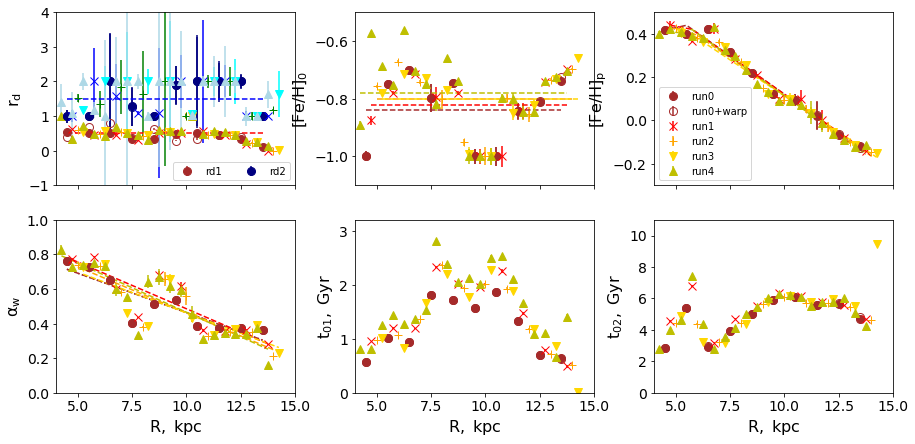

In [10]:
# (iv). Fix Aw, fit (t01, t02)
# -----------------------------------------------

# We use linear law for Aw
popt_aw_run0, pcov = curve_fit(f_p1,R0,aw_run0)
popt_aw_run0w, pcov = curve_fit(f_p1,R0,aw_run0w)
popt_aw_run1, pcov = curve_fit(f_p1,R1,aw_run1)
popt_aw_run2, pcov = curve_fit(f_p1,R2,aw_run2)
popt_aw_run3, pcov = curve_fit(f_p1,R3,aw_run3)
popt_aw_run4, pcov = curve_fit(f_p1,R4,aw_run4)

aw_fit_run0 = f_p1(R0,*popt_aw_run0)
aw_fit_run0w = f_p1(R0,*popt_aw_run0w)
aw_fit_run1 = f_p1(R1,*popt_aw_run1)
aw_fit_run2 = f_p1(R2,*popt_aw_run2)
aw_fit_run3 = f_p1(R3,*popt_aw_run3)
aw_fit_run4 = f_p1(R4,*popt_aw_run4)

# Fit AMR
amrd_fit0 = fit_amrd_reduced3(R0,AMRd_raw0,ia0,rd1_fit,rd2_fit,feh0_fit_run0,fehp_fit_run0,aw_fit_run0)
amrd_fit0w = fit_amrd_reduced3(R0,AMRd_raw0w,ia0w,rd1_fit,rd2_fit,feh0_fit_run0w,fehp_fit_run0w,aw_fit_run0w)
amrd_fit1 = fit_amrd_reduced3(R1,AMRd_raw1,ia1,rd1_fit,rd2_fit,feh0_fit_run1,fehp_fit_run1,aw_fit_run1)
amrd_fit2 = fit_amrd_reduced3(R2,AMRd_raw2,ia2,rd1_fit,rd2_fit,feh0_fit_run2,fehp_fit_run2,aw_fit_run2)
amrd_fit3 = fit_amrd_reduced3(R3,AMRd_raw3,ia3,rd1_fit,rd2_fit,feh0_fit_run3,fehp_fit_run3,aw_fit_run3)
amrd_fit4 = fit_amrd_reduced3(R4,AMRd_raw4,ia4,rd1_fit4,rd2_fit4,feh0_fit_run4,fehp_fit_run4,aw_fit_run4)
(t01_run0,t02_run0),(et01_run0,et02_run0) = amrd_fit0
(t01_run0w,t02_run0w),(et01_run0w,et02_run0w) = amrd_fit0w
(t01_run1,t02_run1),(et01_run1,et02_run1) = amrd_fit1
(t01_run2,t02_run2),(et01_run2,et02_run2) = amrd_fit2
(t01_run3,t02_run3),(et01_run3,et02_run3) = amrd_fit3
(t01_run4,t02_run4),(et01_run4,et02_run4) = amrd_fit4


# Plot parameters and their profiles
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,7))
mrks = 8
# rd1 and rd2 
ax[0,0].errorbar(R0,rd1_run0,yerr=erd1_run0,c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
ax[0,0].errorbar(R0,rd1_run0w,yerr=erd1_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[0,0].errorbar(R1,rd1_run1,yerr=erd1_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd1_run2,yerr=erd1_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd1_run3,yerr=erd1_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd1_run4,yerr=erd1_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,0].errorbar(R0,rd2_run0,yerr=erd2_run0,c='navy',ls='none',marker='o',markersize=mrks,label='rd2')
ax[0,0].errorbar(R0,rd2_run0w,yerr=erd2_run0w,ecolor='navy',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='navy')
ax[0,0].errorbar(R1,rd2_run1,yerr=erd2_run1,c='b',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2,rd2_run2,yerr=erd2_run2,c='g',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3,rd2_run3,yerr=erd2_run3,c='cyan',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4,rd2_run4,yerr=erd2_run4,c='lightblue',ls='none',marker='^',markersize=mrks)
ax[0,0].plot(R0,rd1_fit,ls='--',c='r')
ax[0,0].plot(R0,rd2_fit,ls='--',c='b')
ax[0,0].set_ylabel('$\mathrm{r_d}$',fontsize=fnt1)
ax[0,0].legend(loc=4,ncol=2)
ax[0,0].set_ylim(-1,4)
ax[0,0].set_xlim(4,15)
ax[0,0].set_xticklabels([])
# FeH0
ax[0,1].errorbar(R0,feh0_run0,yerr=efeh0_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[0,1].errorbar(R0,feh0_run0w,yerr=efeh0_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[0,1].errorbar(R1,feh0_run1,yerr=efeh0_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[0,1].errorbar(R2,feh0_run2,yerr=efeh0_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[0,1].errorbar(R3,feh0_run3,yerr=efeh0_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[0,1].errorbar(R4,feh0_run4,yerr=efeh0_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[0,1].plot(R0,feh0_fit_run0,c='brown',ls='--')
ax[0,1].plot(R1,feh0_fit_run1,c='red',ls='--')
ax[0,1].plot(R2,feh0_fit_run2,c='orange',ls='--')
ax[0,1].plot(R3,feh0_fit_run3,c='gold',ls='--')
ax[0,1].plot(R4,feh0_fit_run4,c='y',ls='--')
ax[0,1].set_ylabel('$\mathrm{[Fe/H]_0}$',fontsize=fnt1)
ax[0,1].set_ylim(-1.1,-0.5)
ax[0,1].set_xlim(4,15)
ax[0,1].set_xticklabels([])
# FeHp
ax[0,2].errorbar(R0,fehp_run0,yerr=efehp_run0,c='brown',ls='none',marker='o',markersize=mrks,label='run0')
ax[0,2].errorbar(R0,fehp_run0w,yerr=efehp_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                 label='run0+warp',markerfacecolor='none',markeredgecolor='brown')
ax[0,2].errorbar(R1,fehp_run1,yerr=efehp_run1,c='red',ls='none',marker='x',markersize=mrks,label='run1')
ax[0,2].errorbar(R2,fehp_run2,yerr=efehp_run2,c='orange',ls='none',marker='+',markersize=mrks,label='run2')
ax[0,2].errorbar(R3,fehp_run3,yerr=efehp_run3,c='gold',ls='none',marker='v',markersize=mrks,label='run3')
ax[0,2].errorbar(R4,fehp_run4,yerr=efehp_run4,c='y',ls='none',marker='^',markersize=mrks,label='run4')
ax[0,2].plot(R0,fehp_fit_run0,c='brown',ls='--')
ax[0,2].plot(R1,fehp_fit_run1,c='red',ls='--')
ax[0,2].plot(R2,fehp_fit_run2,c='orange',ls='--')
ax[0,2].plot(R3,fehp_fit_run3,c='gold',ls='--')
ax[0,2].plot(R4,fehp_fit_run4,c='y',ls='--')
ax[0,2].set_ylabel('$\mathrm{[Fe/H]_p}$',fontsize=fnt1)
ax[0,2].set_ylim(-0.3,0.5)
ax[0,2].set_xlim(4,15)
ax[0,2].legend(loc=3)
ax[0,2].set_xticklabels([])
# Aw
ax[1,0].errorbar(R0,aw_run0,yerr=eaw_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,0].errorbar(R0,aw_run0w,yerr=eaw_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,0].errorbar(R1,aw_run1,yerr=eaw_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,0].errorbar(R2,aw_run2,yerr=eaw_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,0].errorbar(R3,aw_run3,yerr=eaw_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,0].errorbar(R4,aw_run4,yerr=eaw_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,0].plot(R0,aw_fit_run0,c='brown',ls='--')
ax[1,0].plot(R0,aw_fit_run0w,c='brown',ls=':')
ax[1,0].plot(R1,aw_fit_run1,c='red',ls='--')
ax[1,0].plot(R2,aw_fit_run2,c='orange',ls='--')
ax[1,0].plot(R3,aw_fit_run3,c='gold',ls='--')
ax[1,0].plot(R4,aw_fit_run4,c='y',ls='--')
ax[1,0].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,0].set_ylabel(r'$\mathrm{\alpha_w}$',fontsize=fnt1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlim(4,15)
# t01
ax[1,1].errorbar(R0,t01_run0,yerr=et01_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,1].errorbar(R0,t01_run0w,yerr=et01_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,1].errorbar(R1,t01_run1,yerr=et01_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,1].errorbar(R2,t01_run2,yerr=et01_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,1].errorbar(R3,t01_run3,yerr=et01_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,1].errorbar(R4,t01_run4,yerr=et01_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,1].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,1].set_ylabel(r'$\mathrm{t_{01}, \ Gyr}$',fontsize=fnt1)
ax[1,1].set_ylim(0,3.2)
ax[1,1].set_xlim(4,15)
# t02
ax[1,2].errorbar(R0,t02_run0,yerr=et02_run0,c='brown',ls='none',marker='o',markersize=mrks)
ax[1,2].errorbar(R0,t02_run0w,yerr=et02_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
                markerfacecolor='none',markeredgecolor='brown')
ax[1,2].errorbar(R1,t02_run1,yerr=et02_run1,c='red',ls='none',marker='x',markersize=mrks)
ax[1,2].errorbar(R2,t02_run2,yerr=et02_run2,c='orange',ls='none',marker='+',markersize=mrks)
ax[1,2].errorbar(R3,t02_run3,yerr=et02_run3,c='gold',ls='none',marker='v',markersize=mrks)
ax[1,2].errorbar(R4,t02_run4,yerr=et02_run4,c='y',ls='none',marker='^',markersize=mrks)
ax[1,2].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax[1,2].set_ylabel(r'$\mathrm{t_{02}, \ Gyr}$',fontsize=fnt1)
ax[1,2].set_ylim(0,11)
ax[1,2].set_xlim(4,15)
fig.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig(os.path.join('output','AMRd_best_params_runs0-4_dm_step4.png'))



From the last plot of AMR parameters we see that t01 and t02 are not monotonous functions of R. From the additional tests which we do not show here, we found that fitting t01 and t02 simply with constants or linear laws as we did for other parameters leads to large inconsistency between the 'raw' AMR and its fit. 
So we use broken linear laws for t01 and t02 parameters. 


R [kpc]      sigma_t01/mean_t01   sigma_t02/mean_t02 (t01-t01_mean)/sigma_t01 (t02-t02_mean)/sigma_t02
4-5                  0.02                 0.16                 0.14                 0.2                 
5-6                  0.02                 0.22                 0.13                 0.18                
6-7                  0.03                 0.12                 0.15                 0.17                
7-8                  0.13                 0.08                 0.23                 0.12                
8-9                  0.02                 0.04                 0.09                 0.07                
9-10                 0.02                 0.01                 0.08                 0.04                
10-11                0.03                 0.0                  0.09                 0.01                
11-12                0.04                 0.0                  0.14                 0.02                
12-13                0.03                 0.0            

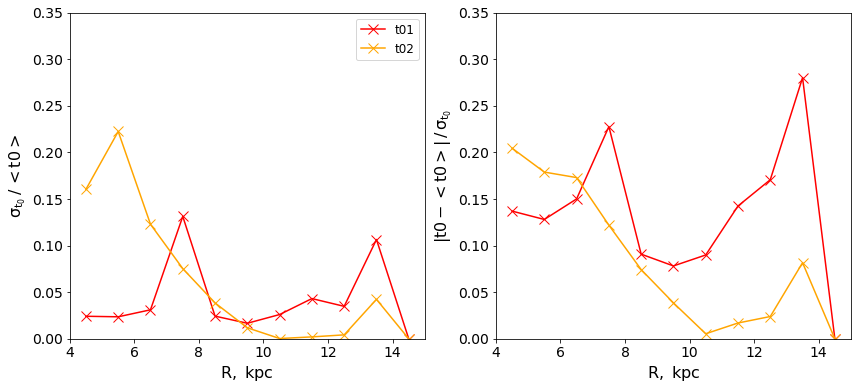

In [11]:
# Estimate scatter of t01, t02, and FeHp in R-bins 
# (this is needed to optimize positions of break points)
# -------------------------------------------------------

R_bins = np.arange(4,16,1)

t01_bins, t02_bins, fehp_bins = [], [], []

for i in range(len(R_bins)-1):
    t01_bins.append([])
    t02_bins.append([])
    fehp_bins.append([])
    # run0
    indr = np.where((R0>=R_bins[i])&(R0<R_bins[i+1]))[0]
    t01_bins[i].extend(np.array(t01_run0)[indr])
    t02_bins[i].extend(np.array(t02_run0)[indr])
    fehp_bins[i].extend(np.array(fehp_run0)[indr])
    # run1
    indr = np.where((R1>=R_bins[i])&(R1<R_bins[i+1]))[0]
    t01_bins[i].extend(np.array(t01_run1)[indr])
    t02_bins[i].extend(np.array(t02_run1)[indr])
    fehp_bins[i].extend(np.array(fehp_run1)[indr])
    # run2
    indr = np.where((R2>=R_bins[i])&(R2<R_bins[i+1]))[0]
    t01_bins[i].extend(np.array(t01_run2)[indr])
    t02_bins[i].extend(np.array(t02_run2)[indr])
    fehp_bins[i].extend(np.array(fehp_run2)[indr])
    # run3
    indr = np.where((R3[:-1]>=R_bins[i])&(R3[:-1]<R_bins[i+1]))[0]
    t01_bins[i].extend(np.array(t01_run3[:-1])[indr])
    t02_bins[i].extend(np.array(t02_run3[:-1])[indr])
    fehp_bins[i].extend(np.array(fehp_run3[:-1])[indr])
    # run4
    indr = np.where((R4>=R_bins[i])&(R4<R_bins[i+1]))[0]
    t01_bins[i].extend(np.array(t01_run4)[indr])
    t02_bins[i].extend(np.array(t02_run4)[indr])
    fehp_bins[i].extend(np.array(fehp_run4)[indr])

# Mean values
t01_bins_mean = [np.mean(i) for i in t01_bins]
t02_bins_mean = [np.mean(i) for i in t02_bins]
fehp_bins_mean = [np.mean(i) for i in fehp_bins]

# Dispersion
t01_bins_dispersion = [np.mean([k*k for k in i]) - np.mean(i)**2 for i in t01_bins]
t02_bins_dispersion = [np.mean([k*k for k in i]) - np.mean(i)**2 for i in t02_bins]
fehp_bins_dispersion = [np.mean([k*k for k in i]) - np.mean(i)**2 for i in fehp_bins]

# Dispersion/Mean
t01_relative_dispersion = np.divide(t01_bins_dispersion,t01_bins_mean)
t02_relative_dispersion = np.divide(t02_bins_dispersion,t02_bins_mean)
fehp_relative_dispersion = np.divide(fehp_bins_dispersion,fehp_bins_mean)

# <|i - Mean|>/Dispersion
t01_relative_deviation = [np.mean([np.abs(k-l) for k in i])/l 
                          for (i,l,m) in zip(t01_bins,t01_bins_mean,t01_bins_dispersion)]
t02_relative_deviation = [np.mean([np.abs(k-l) for k in i])/l 
                          for (i,l,m) in zip(t02_bins,t02_bins_mean,t02_bins_dispersion)]
fehp_relative_deviation = [np.mean([np.abs(k-l) for k in i])/l 
                          for (i,l,m) in zip(fehp_bins,fehp_bins_mean,fehp_bins_dispersion)]

# Print statistics
print('{:<12}'.format('R [kpc]'),'{:<20}'.format('sigma_t01/mean_t01'),'{:<18}'.format('sigma_t02/mean_t02'),
      '{:<20}'.format('(t01-t01_mean)/sigma_t01'),'{:<20}'.format('(t02-t02_mean)/sigma_t02'))
for i in range(len(R_bins)-1):
    print('{:<20}'.format(str(R_bins[i])+'-'+str(R_bins[i+1])),
          '{:<20}'.format(np.round(t01_relative_dispersion[i],2)),
          '{:<20}'.format(np.round(t02_relative_dispersion[i],2)),
          '{:<20}'.format(np.round(t01_relative_deviation[i],2)),
          '{:<20}'.format(np.round(t02_relative_deviation[i],2)))

# Plot 
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
ax1.plot(np.add(R_bins,0.5)[:-1],t01_relative_dispersion,c='r',marker='x',markersize=10,lw=1.5,label='t01')
ax1.plot(np.add(R_bins,0.5)[:-1],t02_relative_dispersion,c='orange',marker='x',markersize=10,lw=1.5,label='t02')
ax1.set_ylabel('$\mathrm{\sigma_{t_{0}}\, / \, <t0>}$',fontsize=fnt1)
ax1.set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax1.set_xlim(4,15)
ax1.set_ylim(0,0.35)
ax1.legend(loc=1,prop={'size':fnt2})

ax2.plot(np.add(R_bins,0.5)[:-1],t01_relative_deviation,c='r',marker='x',markersize=10,lw=1.5)
ax2.plot(np.add(R_bins,0.5)[:-1],t02_relative_deviation,c='orange',marker='x',markersize=10,lw=1.5)
ax2.set_ylabel('$\mathrm{|t0-<t0>| \, / \, \sigma_{t_{0}}}$',fontsize=fnt1)
ax2.set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1)
ax2.set_xlim(4,15)
ax2.set_ylim(0,0.35)

plt.show()
f.savefig(os.path.join('output','t0_scatter_dm.png'))


t01: 	 R_br1 =  7.5 	 R_br2 =  10.0
t02: 	 R_br1 =  6.0 	 R_br2 =  9.75


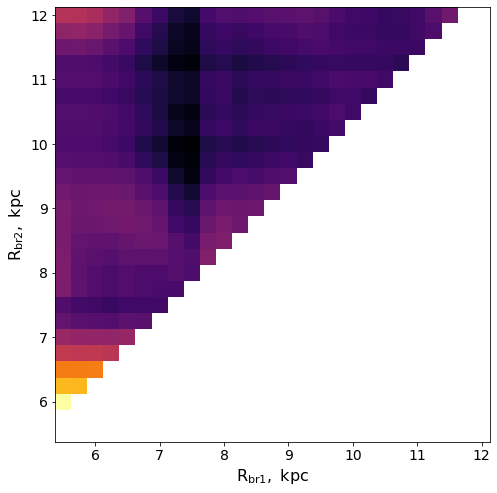

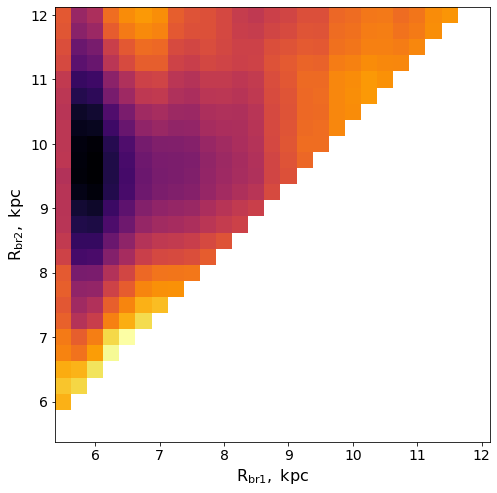

In [12]:
# Optimize R_br for t01 and t02
# ---------------------------------------------------

n_brp = 2     # number of break points
dR = 0.25     # step in R 
Rbr1_arr = np.arange(5.5,12.0+dR,dR)
Rbr2_arr = np.arange(5.5,12.0+dR,dR)

par_dev_t01 = np.zeros((len(Rbr1_arr),len(Rbr2_arr)))
par_dev_t02 = np.zeros((len(Rbr1_arr),len(Rbr2_arr)))


ind_cut = [[0,0],[0,0],[0,0],[0,1],[0,0]]                    
R_mix = mixed_array_simple([R0,R1,R2,R3,R4],ind_cut)
ind_rmix_sorted = np.argsort(R_mix)
R_mix_sorted = np.array(R_mix)[ind_rmix_sorted]
Ntot = len(R_mix)

# Optimization.
# We minimize mean relative deviation <|i - f(R)|>/<Dispersion> 
for i in range(len(Rbr1_arr)):
    
    R_br1 = Rbr1_arr[i]
    ib1 = ind_br(R_br1,R_mix_sorted)

    for k in range(len(Rbr2_arr)):
        
        R_br2 = Rbr2_arr[k]
        
        if R_br2 - R_br1 >=0.5:
            R_br = [R_br1,R_br2]

            ib_run0 = [ind_br(radius,R0) for radius in R_br]
            ib_run1 = [ind_br(radius,R1) for radius in R_br]
            ib_run2 = [ind_br(radius,R2) for radius in R_br]
            ib_run3 = [ind_br(radius,R3) for radius in R_br]
            ib_run4 = [ind_br(radius,R4) for radius in R_br]

            ind_brp = [ib_run0,ib_run1,ib_run2,ib_run3,ib_run4]
            ind_cut = [[0,0],[0,0],[0,0],[0,1],[0,0]]                    

            R_mix_nbr = mixed_array_Nbreaks([R0,R1,R2,R3,R4],ind_brp,ind_cut)
            t01_mix_nbr = mixed_array_Nbreaks([t01_run0,t01_run1,t01_run2,t01_run3,t01_run4],ind_brp,ind_cut)
            t02_mix_nbr = mixed_array_Nbreaks([t02_run0,t02_run1,t02_run2,t02_run3,t02_run4],ind_brp,ind_cut)

            popt_t01_mix_temp, popt_t02_mix_temp = [], [] 
            for l in range(n_brp+1):
                popt_t01_mix_temp.append(curve_fit(f_p1,R_mix_nbr[l],t01_mix_nbr[l])[0])
                popt_t02_mix_temp.append(curve_fit(f_p1,R_mix_nbr[l],t02_mix_nbr[l])[0])

            t01_dev, t02_dev = [], [] 
            for l in range(n_brp+1):    
                R_mix_nbr[l] = np.array(R_mix_nbr[l])
                t01_dev.append(sum(np.abs(t01_mix_nbr[l] - f_p1(R_mix_nbr[l],*popt_t01_mix_temp[l]))))
                t02_dev.append(sum(np.abs(t02_mix_nbr[l] - f_p1(R_mix_nbr[l],*popt_t02_mix_temp[l]))))

            t01_dev_mean = sum(t01_dev)/Ntot
            t02_dev_mean = sum(t02_dev)/Ntot

            par_dev_t01[i,k] = t01_dev_mean/np.mean(t01_bins_dispersion) 
            par_dev_t02[i,k] = t02_dev_mean/np.mean(t02_bins_dispersion)


# Replace zeros by nans for plotting
par_dev_t01[par_dev_t01==0] = np.nan
par_dev_t02[par_dev_t02==0] = np.nan
ind_best_t01 = np.where(par_dev_t01==np.nanmin(par_dev_t01))
ind_best_t02 = np.where(par_dev_t02==np.nanmin(par_dev_t02))
print('t01: \t R_br1 = ',Rbr1_arr[ind_best_t01[0][0]],'\t R_br2 = ',Rbr2_arr[ind_best_t01[1][0]])
print('t02: \t R_br1 = ',Rbr1_arr[ind_best_t02[0][0]],'\t R_br2 = ',Rbr2_arr[ind_best_t02[1][0]])


# And plot
f, ax = plt.subplots(figsize=(10,8))
ax.imshow(np.flipud(par_dev_t01.T),interpolation='none',cmap='inferno',
          extent=[Rbr1_arr[0]-dR/2,Rbr1_arr[-1]+dR/2,Rbr2_arr[0]-dR/2,Rbr2_arr[-1]+dR/2])
ax.set_xlabel('$\mathrm{R_{br1}, \ kpc}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{R_{br2}, \ kpc}$',fontsize=fnt1)
plt.show()
f.savefig(os.path.join('output','Rbr_optimization_lin_nbr_t01_dm.png'))

f, ax = plt.subplots(figsize=(10,8))
ax.imshow(np.flipud(par_dev_t02.T),interpolation='none',cmap='inferno',
          extent=[Rbr1_arr[0]-dR/2,Rbr1_arr[-1]+dR/2,Rbr2_arr[0]-dR/2,Rbr2_arr[-1]+dR/2])
ax.set_xlabel('$\mathrm{R_{br1}, \ kpc}$',fontsize=fnt1)
ax.set_ylabel('$\mathrm{R_{br2}, \ kpc}$',fontsize=fnt1)
plt.show()
f.savefig(os.path.join('output','Rbr_optimization_lin_nbr_t02_dm.png'))


/home/skevja/anaconda2/envs/py3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


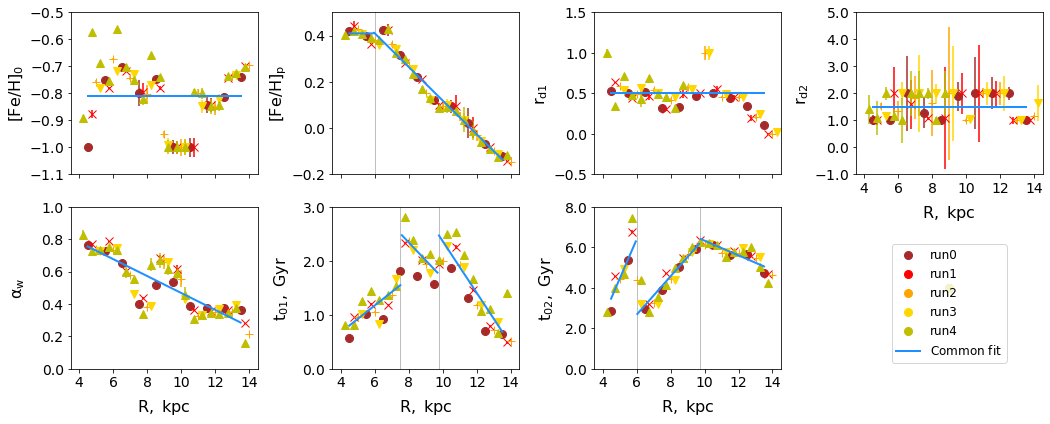

In [91]:
# Finally, construct the global AMR fit 
# ----------------------------------------


R_long = np.linspace(p.Rmin,p.Rmax,100)

# FeH0 (constant)
feh0_mix = mixed_array_simple([feh0_run0,feh0_run1,feh0_run2,feh0_run3,feh0_run4],ind_cut)
popt_feh0_mix = curve_fit(f_p1,R_mix,feh0_mix)[0]
feh0_fit_mix1 = f_p1(R_long,*popt_feh0_mix)
feh0_fit_mix = [np.round(np.mean(feh0_fit_mix1),2) for i in R_long]


# FeHp (const + linear law)
fehp_mix = mixed_array_simple([fehp_run0,fehp_run1,fehp_run2,fehp_run3,fehp_run4],ind_cut)
ind_rmix_sorted = np.argsort(R_mix)
R_mix_sorted = np.array(R_mix)[ind_rmix_sorted]
fehp_mix_sorted = np.array(fehp_mix)[ind_rmix_sorted]

R_br_fehp = 6.0   # adopted break point, kpc 

def f_p1_fehp(r,p01,p11,p12):
    p11 = 0 
    p02 = p01 + (p11-p12)*R_br_fehp/p.Rsun
    ind_br = np.where(r<=R_br_fehp)[0][-1]
    par1 = p01 + p11*(r[:ind_br]/p.Rsun)
    par2 = p02 + p12*(r[ind_br:]/p.Rsun)
    par = np.concatenate((par1,par2),axis=0)
    return par

popt_fehp_mix = curve_fit(f_p1_fehp,R_mix_sorted,fehp_mix_sorted)[0]
ib_fehp_long = ind_br(R_br_fehp,R_long)
fehp_fit_mix = f_p1_fehp(R_long,*popt_fehp_mix)


# Aw (linear law)
aw_mix = mixed_array_simple([aw_run0,aw_run1,aw_run2,aw_run3,aw_run4],ind_cut)
popt_aw_mix = curve_fit(f_p1,R_mix,aw_mix)[0]
aw_fit_mix = f_p1(R_long,*popt_aw_mix)


# t01 (broken linear law)
R_br1 = [7.5,9.75]  # optimized R_br positions, kpc
n_brp = len(R_br1)

ib_run0 = [ind_br(radius,R0) for radius in R_br1]
ib_run1 = [ind_br(radius,R1) for radius in R_br1]
ib_run2 = [ind_br(radius,R2) for radius in R_br1]
ib_run3 = [ind_br(radius,R3) for radius in R_br1]
ib_run4 = [ind_br(radius,R4) for radius in R_br1]

ind_brp = [ib_run0,ib_run1,ib_run2,ib_run3,ib_run4]         
R_mix_nbr1 = mixed_array_Nbreaks([R0,R1,R2,R3,R4],ind_brp,ind_cut)
t01_mix_nbr = mixed_array_Nbreaks([t01_run0,t01_run1,t01_run2,t01_run3,t01_run4],ind_brp,ind_cut)

ib_long = [ind_br(radius,R_long) for radius in R_br1] 
ib_long_full1 = [0] + ib_long + [len(R_long)]

popt_t01_mix = [] 
for i in range(n_brp+1):
    popt_t01_mix.append(curve_fit(f_p1,R_mix_nbr1[i],t01_mix_nbr[i])[0])
t01_fit_mix = [f_p1(R_long[ib_long_full1[i]:ib_long_full1[i+1]],*popt) 
                   for (popt,i) in zip(popt_t01_mix,np.arange(n_brp+1))]


# t02 (broken linear law)
R_br2 = [6.0,9.75]  # we adopt first break point to be the same as for FeHp, 6.0 kpc, 
                    # as the best optimized value is very close, 6.25 kpc.
n_brp = len(R_br2)
                                 
ib_run0 = [ind_br(radius,R0) for radius in R_br2]
ib_run1 = [ind_br(radius,R1) for radius in R_br2]
ib_run2 = [ind_br(radius,R2) for radius in R_br2]
ib_run3 = [ind_br(radius,R3) for radius in R_br2]
ib_run4 = [ind_br(radius,R4) for radius in R_br2]

ind_brp = [ib_run0,ib_run1,ib_run2,ib_run3,ib_run4]         
R_mix_nbr2 = mixed_array_Nbreaks([R0,R1,R2,R3,R4],ind_brp,ind_cut)
t02_mix_nbr = mixed_array_Nbreaks([t02_run0,t02_run1,t02_run2,t02_run3,t02_run4],ind_brp,ind_cut)
                 
ib_long = [ind_br(radius,R_long) for radius in R_br2] 
ib_long_full2 = [0] + ib_long + [len(R_long)]

popt_t02_mix = [] 
for i in range(n_brp+1):
    popt_t02_mix.append(curve_fit(f_p1,R_mix_nbr2[i],t02_mix_nbr[i])[0])
t02_fit_mix = [f_p1(R_long[ib_long_full2[i]:ib_long_full2[i+1]],*popt) 
                   for (popt,i) in zip(popt_t02_mix,np.arange(n_brp+1))]


# Plot the best parameters and their common profiles
erd2_run4 = np.array(erd2_run4)
erd2_run4[erd2_run4>1]=np.mean(erd2_run4)

fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(15,6))

mrks = 8
lbp = 3
mix_col = 'dodgerblue'
# FeH0
ax[0,0].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 feh0_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=efeh0_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks)
#ax[0,0].errorbar(R0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 feh0_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 yerr=efeh0_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],ecolor='brown',
#                 ls='none',marker='o',markersize=mrks,markerfacecolor='none',markeredgecolor='brown')
ax[0,0].errorbar(R1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 feh0_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 yerr=efeh0_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[0,0].errorbar(R2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 feh0_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 yerr=efeh0_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[0,0].errorbar(R3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 feh0_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 yerr=efeh0_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[0,0].errorbar(R4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 feh0_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 yerr=efeh0_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
ax[0,0].plot(R_long,feh0_fit_mix,c=mix_col,lw=2,zorder=50)
ax[0,0].set_ylabel('$\mathrm{[Fe/H]_0}$',fontsize=fnt1,labelpad=lbp)
ax[0,0].set_ylim(-1.1,-0.5)
ax[0,0].set_xlim(3.5,14.5)
ax[0,0].set_xticklabels([])
ax[0,0].set_yticks(np.arange(-1.1,-0.4,0.1))
ax[0,0].set_xticks(np.arange(4,16,2))
ax[0,0].yaxis.set_major_formatter(FormatStrFormatter('$\mathrm{%.1f}$'))
# FeHp
ax[0,1].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 fehp_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=efehp_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks)
#ax[0,1].errorbar(R0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 fehp_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 yerr=efehp_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],ecolor='brown',
#                 ls='none',marker='o',markersize=mrks,markerfacecolor='none',markeredgecolor='brown')
ax[0,1].errorbar(R1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 fehp_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 yerr=efehp_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[0,1].errorbar(R2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 fehp_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 yerr=efehp_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[0,1].errorbar(R3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 fehp_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 yerr=efehp_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[0,1].errorbar(R4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 fehp_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 yerr=efehp_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
ax[0,1].plot(R_long,fehp_fit_mix,c=mix_col,lw=2,zorder=50)
ax[0,1].plot([R_br2[0],R_br2[0]],[-0.2,0.5],lw=0.5,c='gray')
ax[0,1].set_ylabel('$\mathrm{[Fe/H]_p}$',fontsize=fnt1,labelpad=lbp)
ax[0,1].set_ylim(-0.2,0.5)
ax[0,1].set_xlim(3.5,14.5)
ax[0,1].set_xticks(np.arange(4,16,2))
ax[0,1].set_xticklabels([])
# rd1
ax[0,2].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd1_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=erd1_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
#ax[0,2].errorbar(R0,rd1_run0w,yerr=erd1_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
#                markerfacecolor='none',markeredgecolor='brown')
ax[0,2].errorbar(R1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd1_run1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=erd1_run1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[0,2].errorbar(R2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd1_run2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=erd1_run2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[0,2].errorbar(R3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd1_run3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=erd1_run3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[0,2].errorbar(R4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd1_run4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=erd1_run4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
ax[0,2].plot(R_long,[0.5 for i in R_long],c=mix_col,lw=2,zorder=50)
ax[0,2].set_ylabel('$\mathrm{r_{d1}}$',fontsize=fnt1,labelpad=lbp)
ax[0,2].set_ylim(-0.5,1.5)
ax[0,2].set_xlim(3.5,14.5)
ax[0,2].set_xticks(np.arange(4,16,2))
ax[0,2].set_xticklabels([])
# rd2
fx = 1 
ax[0,3].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd2_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=np.multiply(fx,erd2_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]]),
                 c='brown',ls='none',marker='o',markersize=mrks,label='rd1')
#ax[0,3].errorbar(R0,rd2_run0w,yerr=erd2_run0w,ecolor='brown',ls='none',marker='o',markersize=mrks,
#                markerfacecolor='none',markeredgecolor='brown')
ax[0,3].errorbar(R1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd2_run1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=np.multiply(fx,erd2_run1[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]]),
                 c='red',ls='none',marker='x',markersize=mrks)
ax[0,3].errorbar(R2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd2_run2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=np.multiply(fx,erd2_run2[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]]),
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[0,3].errorbar(R3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd2_run3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=np.multiply(fx,erd2_run3[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]]),
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[0,3].errorbar(R4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 rd2_run4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=np.multiply(fx,erd2_run4[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]]),
                 c='y',ls='none',marker='^',markersize=mrks)
ax[0,3].plot(R_long,[1.5 for i in R_long],c=mix_col,lw=2,zorder=50)
ax[0,3].set_ylabel('$\mathrm{r_{d2}}$',fontsize=fnt1,labelpad=lbp)
ax[0,3].set_ylim(-1,5)
ax[0,3].set_xlim(3.5,14.5)
ax[0,3].set_yticks(np.arange(-1,6))
ax[0,3].yaxis.set_major_formatter(FormatStrFormatter('$\mathrm{%.1f}$'))
ax[0,3].set_xticks(np.arange(4,16,2))
ax[0,3].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1,labelpad=lbp+5)
# Aw
ax[1,0].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 aw_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=eaw_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks)
#ax[1,0].errorbar(R0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 aw_run0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 yerr=eaw_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],ecolor='brown',
#                 ls='none',marker='o',markersize=mrks,markerfacecolor='none',markeredgecolor='brown')
ax[1,0].errorbar(R1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 aw_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 yerr=eaw_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[1,0].errorbar(R2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 aw_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 yerr=eaw_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[1,0].errorbar(R3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 aw_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 yerr=eaw_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[1,0].errorbar(R4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 aw_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 yerr=eaw_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
ax[1,0].plot(R_long,aw_fit_mix,c=mix_col,lw=2,zorder=50)
ax[1,0].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1,labelpad=lbp+5)
ax[1,0].set_ylabel(r'$\mathrm{\alpha_w}$',fontsize=fnt1,labelpad=lbp+12)
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlim(3.5,14.5)
ax[1,0].set_xticks(np.arange(4,16,2))
# t01
ax[1,1].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 t01_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=et01_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks)
#ax[1,1].errorbar(R0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 t01_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 yerr=et01_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],ecolor='brown',
#                 ls='none',marker='o',markersize=mrks,markerfacecolor='none',markeredgecolor='brown')
ax[1,1].errorbar(R1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 t01_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 yerr=et01_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[1,1].errorbar(R2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 t01_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 yerr=et01_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[1,1].errorbar(R3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 t01_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 yerr=et01_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[1,1].errorbar(R4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 t01_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 yerr=et01_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
for i in range(n_brp+1):
    ax[1,1].plot(R_long[ib_long_full1[i]:ib_long_full1[i+1]],t01_fit_mix[i],c=mix_col,lw=2,zorder=50)
for i in range(n_brp):
    ax[1,1].plot([R_br1[i],R_br1[i]],[0,3],lw=0.5,c='gray')
ax[1,1].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1,labelpad=lbp+5)
ax[1,1].set_ylabel(r'$\mathrm{t_{01}, \ Gyr}$',fontsize=fnt1,labelpad=lbp+8)
ax[1,1].set_ylim(0,3)
ax[1,1].set_xlim(3.5,14.5)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('$\mathrm{%.1f}$'))
ax[1,1].set_xticks(np.arange(4,16,2))
# t02
ax[1,2].errorbar(R0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 t02_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 yerr=et02_run0[ind_cut[0][0]:len(feh0_run0)-ind_cut[0][1]],
                 c='brown',ls='none',marker='o',markersize=mrks)
#ax[1,2].errorbar(R0[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 t02_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],
#                 yerr=et02_run0w[ind_cut[0][0]:len(feh0_run0w)-ind_cut[0][1]],ecolor='brown',
#                 ls='none',marker='o',markersize=mrks,markerfacecolor='none',markeredgecolor='brown')
ax[1,2].errorbar(R1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 t02_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 yerr=et02_run1[ind_cut[1][0]:len(feh0_run1)-ind_cut[1][1]],
                 c='red',ls='none',marker='x',markersize=mrks)
ax[1,2].errorbar(R2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 t02_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 yerr=et02_run2[ind_cut[2][0]:len(feh0_run2)-ind_cut[2][1]],
                 c='orange',ls='none',marker='+',markersize=mrks)
ax[1,2].errorbar(R3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 t02_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 yerr=et02_run3[ind_cut[3][0]:len(feh0_run3)-ind_cut[3][1]],
                 c='gold',ls='none',marker='v',markersize=mrks)
ax[1,2].errorbar(R4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 t02_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 yerr=et02_run4[ind_cut[4][0]:len(feh0_run4)-ind_cut[4][1]],
                 c='y',ls='none',marker='^',markersize=mrks)
for i in range(n_brp+1):
    ax[1,2].plot(R_long[ib_long_full2[i]:ib_long_full2[i+1]],t02_fit_mix[i],c=mix_col,lw=2,zorder=50)
for i in range(n_brp):
    ax[1,2].plot([R_br2[i],R_br2[i]],[0,11],lw=0.5,c='gray')
ax[1,2].set_xlabel('$\mathrm{R, \ kpc}$',fontsize=fnt1,labelpad=lbp+5)
ax[1,2].set_ylabel(r'$\mathrm{t_{02}, \ Gyr}$',fontsize=fnt1,labelpad=lbp+5)
ax[1,2].set_ylim(0,8)
ax[1,2].set_xlim(3.5,14.5)
ax[1,2].set_xticks(np.arange(4,16,2))
ax[1,2].yaxis.set_major_formatter(FormatStrFormatter('$\mathrm{%.1f}$'))

ax[1,3].set_axis_off()
ax[1,3].plot([-1],[-1],c='brown',ls='none',marker='o',markersize=mrks,label='run0')
#ax[1,3].plot([-1],[-1],markerfacecolor='none',markeredgecolor='brown',ls='none',marker='o',markersize=mrks,
#             label='run0+warp')
ax[1,3].plot([-1],[-1],c='red',ls='none',marker='o',markersize=mrks,label='run1')
ax[1,3].plot([-1],[-1],c='orange',ls='none',marker='o',markersize=mrks,label='run2')
ax[1,3].plot([-1],[-1],c='gold',ls='none',marker='o',markersize=mrks,label='run3')
ax[1,3].plot([-1],[-1],c='y',ls='none',marker='o',markersize=mrks,label='run4')
ax[1,3].plot([-1],[-1],lw=2,c=mix_col,label='$\mathrm{Common \ fit}$')
ax[1,3].legend(loc='lower center',prop={'size':fnt2})
fig.subplots_adjust(left=0.07,right=0.97,top=0.95,wspace=0.4,hspace=0.2)
plt.show()
fig.savefig(os.path.join('output','AMRd_best_params_fit_mix_runs0-4_dm.pdf'))


[0.5341506664563896,
 0.6203803635767857,
 0.25267733539582865,
 0.23953327161028684,
 2.205400888514551,
 1.2848389783733607,
 21.225676498514034,
 0.20998406765996297,
 0.11508371547016355,
 2.459229688277267,
 1.9796683336128522,
 1.465485123031681,
 0.11441573228800465,
 0.16401250949165744,
 0.7431561166586932,
 1.0149147861117906,
 0.3444501124475533,
 0.274052959524396,
 0.0945592682773939,
 0.38921159221038926]

In [15]:
# And let's don't forget about the thick disk component 
# In this case, fitting is much simpler

def amrt_sj21n(t,t0,r,FeH_0,FeH_p):
    # Law to fit the thick-disk AMR
    FeH = FeH_0 + (FeH_p - FeH_0)*np.tanh(np.divide(t,t0))**r/np.tanh(np.divide(tp,t0))**r
    return FeH

amrt_raw0 = np.loadtxt(os.path.join(dir0,'met','tab','AMRt_apogee_rc_dr16.txt')).T
AMRt_raw0 = amrt_raw0[1]

poptt, pcovt = curve_fit(amrt_sj21n,amrt_raw0[0],AMRt_raw0)

AMRt_fit = amrt_sj21n(amrt_raw0[0],*poptt)


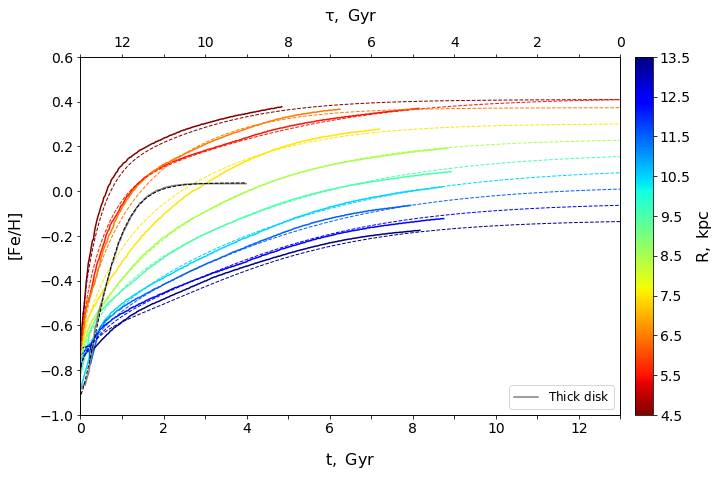

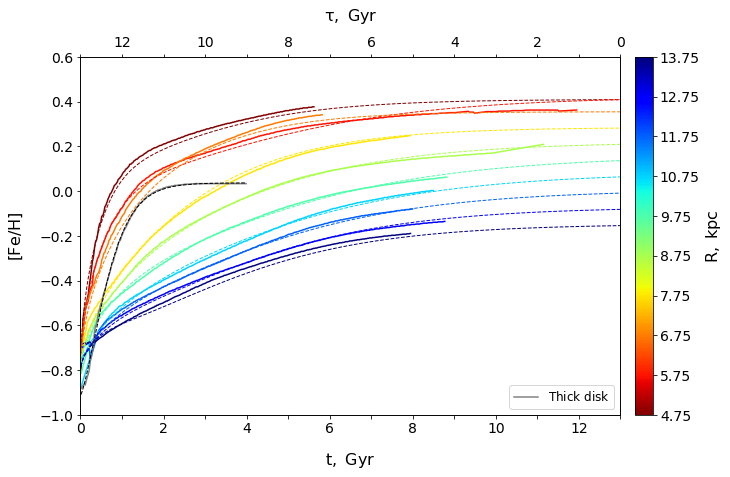

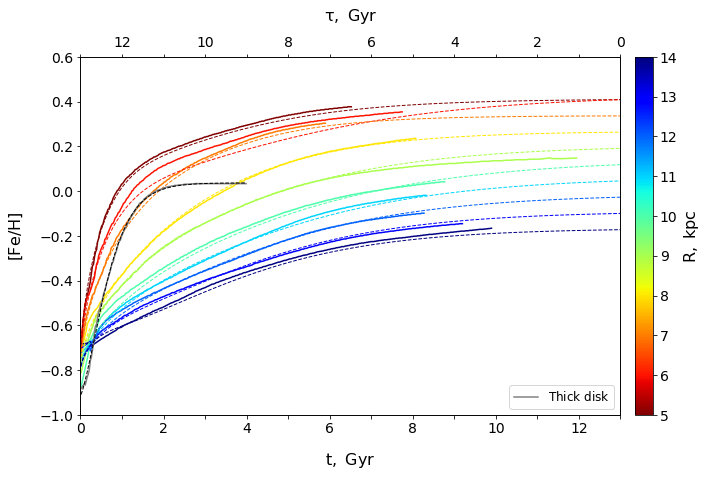

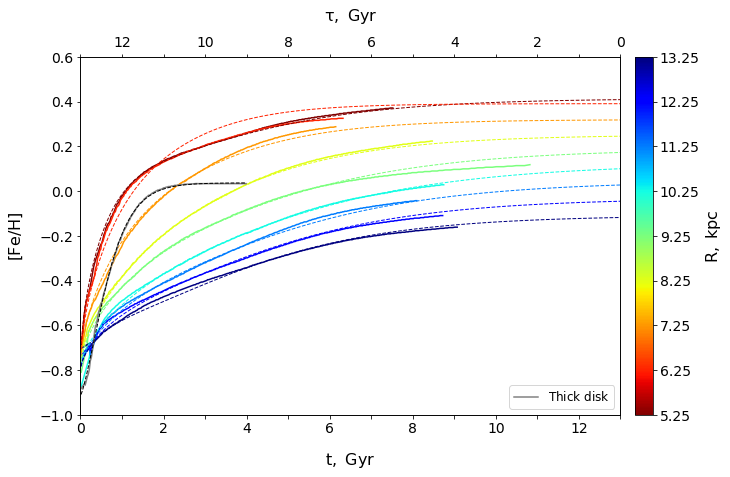

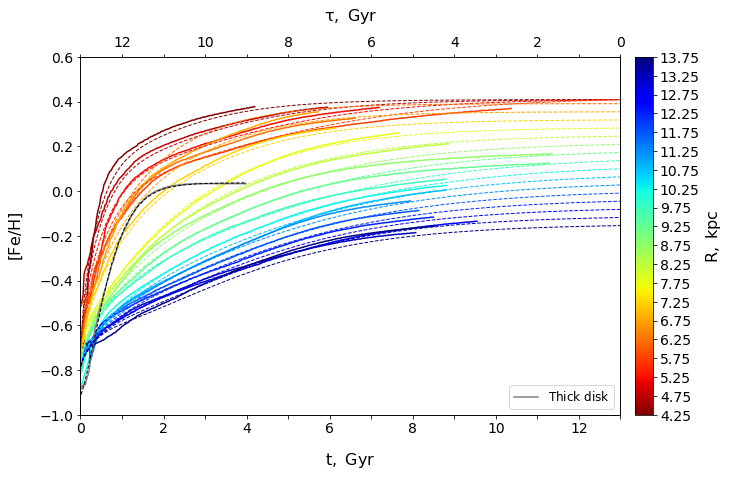

In [16]:
# Finally, plot the 'raw' thin-disk AMR and its global fit 


def f_p1_fehp(r,p01,p11,p12):
    p11 = 0 
    p02 = p01 + (p11-p12)*R_br_fehp/p.Rsun
    if r <= R_br_fehp:
        par = p01 + p11*(r/p.Rsun)
    else:
        par = p02 + p12*(r/p.Rsun)
    return par


def plot_amr_and_fit(R,amrd_data,ia,amrd_fit,figname):
   
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim((0,tp))
    ax.set_ylim((-1.0,0.6))
    ax.set_xticks(np.arange(tp+1))
    ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
    ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
    ax.set_ylabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
    axx = ax.twiny()
    axx.set_xticks(np.arange(tp+1))
    axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
    axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
    fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)

    line_segments1 = LineCollection([list(zip(a.t[:ia[i]],amrd_data[i][:ia[i]])) for i in np.arange(len(R))],
                                     linewidths=1.5,cmap = mpl.cm.jet_r,
                                     norm = mpl.colors.Normalize(vmin=R[0],vmax=R[-1]))   
    line_segments2 = LineCollection([list(zip(a.t,amrd_fit[i])) for i in np.arange(len(R))],
                                     linewidths=1,ls='--',cmap = mpl.cm.jet_r,
                                     norm = mpl.colors.Normalize(vmin=R[0],vmax=R[-1]))
    line_segments1.set_array(R)
    im = ax.add_collection(line_segments1)
    line_segments2.set_array(R)
    im = ax.add_collection(line_segments2)
    ax.plot(a.t[:a.jt],AMRt_raw0,lw=1.5,c='grey',label='$\mathrm{Thick \ disk}$')
    ax.plot(a.t[:a.jt],AMRt_fit,lw=1,ls='--',c='k')
    ax.legend(loc=4,prop={'size':fnt2})
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_ticks(R)
    cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
    plt.show()
    fig.savefig(os.path.join('output','AMRd_'+figname+'.png'))
    
    

# AMR with the fitted parameters
R_br1 = [7.5,9.75]
R_br2 = [6.0,9.75]
R_int1 = [p.Rmin-1] + R_br1 + [p.Rmax+1]
R_int2 = [p.Rmin-1] + R_br2 + [p.Rmax+1]

AMRd_pfit = np.zeros((4,Rbins,a.jd))
AMRd_pfit4 = np.zeros((Rbins4,a.jd))

for i in range(Rbins):
    
    k01 = int(len(np.where(R_int1<R0[i])[0]) - 1)   
    k11 = int(len(np.where(R_int1<R1[i])[0]) - 1)   
    k21 = int(len(np.where(R_int1<R2[i])[0]) - 1)   
    k31 = int(len(np.where(R_int1<R3[i])[0]) - 1) 
    k02 = int(len(np.where(R_int2<R0[i])[0]) - 1)   
    k12 = int(len(np.where(R_int2<R1[i])[0]) - 1)   
    k22 = int(len(np.where(R_int2<R2[i])[0]) - 1)   
    k32 = int(len(np.where(R_int2<R3[i])[0]) - 1) 
    
    AMRd_pfit[0,i] = f_amrd5n(a.t,f_p1(R0[i],*popt_t01_mix[k01]),rd1_fit[i],
                                  f_p1(R0[i],*popt_t02_mix[k02]),rd2_fit[i],feh0_fit_mix[0],
                                  f_p1_fehp(R0[i],*popt_fehp_mix),f_p1(R0[i],*popt_aw_mix))
    AMRd_pfit[1,i] = f_amrd5n(a.t,f_p1(R1[i],*popt_t01_mix[k11]),rd1_fit[i],
                                  f_p1(R1[i],*popt_t02_mix[k12]),rd2_fit[i],feh0_fit_mix[0],
                                  f_p1_fehp(R1[i],*popt_fehp_mix),f_p1(R1[i],*popt_aw_mix))
    AMRd_pfit[2,i] = f_amrd5n(a.t,f_p1(R2[i],*popt_t01_mix[k21]),rd1_fit[i],
                                  f_p1(R2[i],*popt_t02_mix[k22]),rd2_fit[i],feh0_fit_mix[0],
                                  f_p1_fehp(R2[i],*popt_fehp_mix),f_p1(R2[i],*popt_aw_mix))
    AMRd_pfit[3,i] = f_amrd5n(a.t,f_p1(R3[i],*popt_t01_mix[k31]),rd1_fit[i],
                                  f_p1(R3[i],*popt_t02_mix[k32]),rd2_fit[i],feh0_fit_mix[0],
                                  f_p1_fehp(R3[i],*popt_fehp_mix),f_p1(R3[i],*popt_aw_mix))

for i in range(Rbins4):
    
    k41 = int(len(np.where(R_int1<R4[i])[0]) - 1)
    k42 = int(len(np.where(R_int2<R4[i])[0]) - 1)
    
    AMRd_pfit4[i] = f_amrd5n(a.t,f_p1(R4[i],*popt_t01_mix[k41]),rd1_fit4[i],
                                 f_p1(R4[i],*popt_t02_mix[k42]),rd2_fit4[i],feh0_fit_mix[0],
                                 f_p1_fehp(R4[i],*popt_fehp_mix),f_p1(R4[i],*popt_aw_mix))

plot_amr_and_fit(R0,AMRd_raw0,ia0,AMRd_pfit[0],'global_fit_run0_dm')
plot_amr_and_fit(R1,AMRd_raw1,ia1,AMRd_pfit[1],'global_fit_run1_dm')
plot_amr_and_fit(R2,AMRd_raw2,ia2,AMRd_pfit[2],'global_fit_run2_dm')
plot_amr_and_fit(R3[:-1],AMRd_raw3[:-1],ia3[:-1],AMRd_pfit[3][:-1],'global_fit_run3_dm')
plot_amr_and_fit(R4,AMRd_raw4,ia4,AMRd_pfit4,'global_fit_run4_dm')



In [18]:
# Print the summary of parameters

print('THIN DISK')
print('{:<5}'.format('rd1'),': 0.5')
print('{:<5}'.format('rd2'),': 1.5')
print('{:<5}'.format('FeH0'),':',feh0_fit_mix[0])
print('{:<5}'.format('Aw'),': k =',round(popt_aw_mix[1],2),', b =',round(popt_aw_mix[0],2))
print('{:<5}'.format('FeHp'),':\n',
      '{:^30}'.format('R <= '+str(R_br2[0])+' kpc'),
                     ': ',round(fehp_fit_mix[0],2),'\n',
      '{:^30}'.format('R > '+str(R_br2[0])+' kpc'), 
                     ': k =',round(popt_fehp_mix[2],2), 
                     ', b =',round(popt_fehp_mix[0] + (0-popt_fehp_mix[2])*R_br2[0]/p.Rsun,2))
print('{:<5}'.format('t01'),':\n',
      '{:^30}'.format('R <= '+str(R_br1[0])+' kpc'),
                     ': k =',round(popt_t01_mix[0][1],2),', b =',round(popt_t01_mix[0][0],2),'\n',
      '{:^30}'.format(str(R_br1[0])+' kpc < R <= '+str(R_br1[1])+' kpc'),
                     ': k =',round(popt_t01_mix[1][1],2),', b =',round(popt_t01_mix[1][0],2),'\n',
      '{:^30}'.format('R > '+str(R_br1[1])+' kpc'),
                     ': k =',round(popt_t01_mix[2][1],2),', b =',round(popt_t01_mix[2][0],2))
print('{:<5}'.format('t02'),':\n',
      '{:^30}'.format('R <= '+str(R_br2[0])+' kpc'),
                     ': k =',round(popt_t02_mix[0][1],2),', b =',round(popt_t02_mix[0][0],2),'\n',
      '{:^30}'.format(str(R_br2[0])+' kpc < R <= '+str(R_br2[1])+' kpc'),
                     ': k =',round(popt_t02_mix[1][1],2),', b =',round(popt_t02_mix[1][0],2),'\n',
      '{:^30}'.format('R > '+str(R_br2[1])+' kpc'),
                     ': k =',round(popt_t02_mix[2][1],2),', b =',round(popt_t02_mix[2][0],2))
#print(popt_fehp_mix)
print('\nTHICK DISK')
print('{:<5}'.format('t0'),':',round(poptt[0],2))
print('{:<5}'.format('rt'),':',round(poptt[1],2))
print('{:<5}'.format('FeH0'),':',round(poptt[2],2))
print('{:<5}'.format('FeHp'),':',round(poptt[3],2))


# And write parameters to the file
f = open(os.path.join('output','AMR_global_fit_params_dm.txt'),'w')
f.write('THIN DISK\n')
f.write('{:<5}'.format('rd1')+': 0.5\n')
f.write('{:<5}'.format('rd2')+': 1.5\n')
f.write('{:<5}'.format('FeH0')+':'+str(feh0_fit_mix[0])+'\n')
f.write('{:<5}'.format('Aw')+': k = '+str(round(popt_aw_mix[1],2))+', b = '+str(round(popt_aw_mix[0],2))+'\n')
f.write('{:<5}'.format('FeHp')+': k = '+str(round(popt_fehp_mix[1],2))+\
        ', b = '+str(round(popt_fehp_mix[0],2))+'\n')
f.write('{:<5}'.format('FeHp')+':\n'+\
      '{:^30}'.format('R <= '+str(R_br2[0])+' kpc')+\
                     ': '+str(round(fehp_fit_mix[0],2))+'\n'+\
      '{:^30}'.format('R > '+str(R_br2[0])+' kpc')+\
                     ': k = '+str(round(popt_fehp_mix[2],2))+\
                     ', b = '+str(round(popt_fehp_mix[0] +\
                                       (0-popt_fehp_mix[2])*R_br2[0]/p.Rsun,2))+'\n')
f.write('{:<5}'.format('t01')+':\n'+\
      '{:^30}'.format('R <= '+str(R_br1[0])+' kpc')+\
                     ': k = '+str(round(popt_t01_mix[0][1],2))+', b = '+str(round(popt_t01_mix[0][0],2))+'\n'+\
      '{:^30}'.format(str(R_br1[0])+' kpc < R <= '+str(R_br1[1])+' kpc')+
                     ': k = '+str(round(popt_t01_mix[1][1],2))+', b = '+str(round(popt_t01_mix[1][0],2))+'\n'+\
      '{:^30}'.format('R > '+str(R_br1[1])+' kpc')+\
                     ': k = '+str(round(popt_t01_mix[2][1],2))+', b = '+str(round(popt_t01_mix[2][0],2))+'\n')
f.write('{:<5}'.format('t02')+':\n'+\
      '{:^30}'.format('R <= '+str(R_br2[0])+' kpc')+\
                     ': k = '+str(round(popt_t02_mix[0][1],2))+', b = '+str(round(popt_t02_mix[0][0],2))+'\n'+\
      '{:^30}'.format(str(R_br2[0])+' kpc < R <= '+str(R_br2[1])+' kpc')+
                     ': k = '+str(round(popt_t02_mix[1][1],2))+', b = '+str(round(popt_t02_mix[1][0],2))+'\n'+\
      '{:^30}'.format('R > '+str(R_br2[1])+' kpc')+\
                     ': k = '+str(round(popt_t02_mix[2][1],2))+', b = '+str(round(popt_t02_mix[2][0],2))+'\n')
f.write('\nTHICK DISK\n')
f.write('{:<5}'.format('t0')+':'+str(round(poptt[0],2))+'\n')
f.write('{:<5}'.format('rt')+':'+str(round(poptt[1],2))+'\n')
f.write('{:<5}'.format('FeH0')+':'+str(round(poptt[2],2))+'\n')
f.write('{:<5}'.format('FeHp')+':'+str(round(poptt[3],2))+'\n')
f.close()


THIN DISK
rd1   : 0.5
rd2   : 1.5
FeH0  : -0.81
Aw    : k = -0.43 , b = 0.99
FeHp  :
          R <= 6.0 kpc          :  0.41 
          R > 6.0 kpc           : k = -0.59 , b = 0.85
t01   :
          R <= 7.5 kpc          : k = 2.04 , b = -0.32 
    7.5 kpc < R <= 9.75 kpc     : k = -2.71 , b = 4.99 
          R > 9.75 kpc          : k = -3.91 , b = 7.14
t02   :
          R <= 6.0 kpc          : k = 15.89 , b = -5.29 
    6.0 kpc < R <= 9.75 kpc     : k = 7.77 , b = -3.04 
          R > 9.75 kpc          : k = -2.97 , b = 9.96

THICK DISK
t0    : 0.9
rt    : 1.28
FeH0  : -0.91
FeHp  : 0.04
